# **😈 Protein Hunter (Chai)**

## Overview

**Protein Hunter** is a computational tool for *de novo* protein design and optimization using AI models. It combines:
- **Chai-Lab**: Structure prediction model
- **LigandMPNN**: Sequence design model

The tool iteratively designs protein sequences and predicts their structures to create proteins with desired properties, including protein binders and ligand binders.

**❗ Display Recommendation:**
The viewer and visualization tools are optimized for light mode.

**❗ WARNING:** the following pipeline is in active development and has NOT been experimentally validated in lab. We are releasing the code to allow the community to contribute and build on.

**📧 Contact**
For feedback, questions or collaboration opportunities, please email yehlin@mit.edu

**➡️ Reference**
We implemented the visualization of designing trajectories using logMD and py2Dmol

---

## Features

✨ **Design Modes** (and recommended options)
- **Unconditional Design**: Create novel proteins from scratch
  - `percent_X`=`0`
  - `temperature`=`0.1`
  - `hysteresis_mode`=`templates`
- **Protein Binders**: Design proteins that bind to target proteins
  - `percent_X`=`50`
  - `temperature`=`0.1`
  - `hysteresis_mode`=`templates`
- **Ligand Binders**: Design proteins that bind to small molecules (SMILES input)
  - `target_seq`=`O=C(NCc1cocn1)c1cnn(C)c1C(=O)Nc1ccn2cc(nc2n1)c1ccccc1` (smile string)
  - `percent_X`=`50`
  - `temperature`=`0.01`
  - `hysteresis_mode`=`esm`

🔄 **Optimization Strategies**
- Template-based hysteresis (reuse previous structures)
- ESM embeddings (protein language model features)
- Partial diffusion refinement
- Multiple trial runs with automatic best selection

In [2]:
# @title Install
import importlib.util
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import csv

if importlib.util.find_spec("chai_lab") is not None:
  print("Chai is already installed!")
else:
  import os
  import subprocess
  import threading

  def setup_models():
      """Install aria2 and download all Chai models"""
      # Install aria2
      os.system("apt-get install -y -qq aria2")

      # Setup paths
      #base_url = "https://chaiassets.com/chai1-inference-depencencies"
      base_url = "http://files.ipd.uw.edu/pub/protein_hunter/chai1"
      dl_dir = "/usr/local/lib/python3.12/dist-packages/downloads"
      os.makedirs(f"{dl_dir}/models_v2", exist_ok=True)
      os.makedirs(f"{dl_dir}/esm", exist_ok=True)

      # Download files individually with appropriate settings
      downloads = [
          (f"{dl_dir}", "conformers_v1.apkl", "-x16 -s16"),
          (f"{dl_dir}/esm", "esm2/traced_sdpa_esm2_t36_3B_UR50D_fp16.pt", "-x16 -s16"),
          (f"{dl_dir}/models_v2", "models_v2/trunk.pt", "-x16 -s16"),
          (f"{dl_dir}/models_v2", "models_v2/diffusion_module.pt", "-x16 -s16"),
          (f"{dl_dir}/models_v2", "models_v2/confidence_head.pt", "-x8"),
          (f"{dl_dir}/models_v2", "models_v2/feature_embedding.pt", ""),
          (f"{dl_dir}/models_v2", "models_v2/token_embedder.pt", ""),
          (f"{dl_dir}/models_v2", "models_v2/bond_loss_input_proj.pt", "")
      ]

      for target_dir, url_path, opts in downloads:
          url = f"{base_url}/{url_path}"
          subprocess.run(f"aria2c {opts} --dir={target_dir} {url}", shell=True, check=True)

  # Start model downloads in background
  print("Starting model downloads...")
  download_thread = threading.Thread(target=setup_models)
  download_thread.start()

  # Install chai in parallel
  print("Installing chai-lab...")
  os.system("pip install --no-deps git+https://github.com/sokrypton/chai-lab.git \
  'gemmi~=0.6.3' 'jaxtyping>=0.2.25' 'pandera>=0.24' 'antipickle==0.2.0' \
  'rdkit~=2024.9.5' 'modelcif>=1.0' 'biopython>=1.83' typing_inspect \
  ihm mypy_extensions equinox wadler_lindig py3Dmol")

  print("Installing LigandMPNN...")
  os.system("git clone https://github.com/sokrypton/LigandMPNN.git")
  os.system("mkdir model_params")
  os.system("bash LigandMPNN/get_model_params.sh model_params")
  os.system("pip install git+https://github.com/prody/ProDy.git")
  os.system("pip install ml_collections")
  os.system("pip install git+https://github.com/sokrypton/py2Dmol.git")

  # Wait for downloads to complete
  print("Waiting for downloads...")
  download_thread.join()
  print("Setup complete!")

Chai is already installed!


In [3]:
# @title load predict libs
import gc
import random
import tempfile
import os
import copy
from dataclasses import dataclass, replace
from pathlib import Path
from typing import Optional, List, Tuple, Dict, Union, Any

import torch
import torch.nn.functional as F
from torch import Tensor
from einops import repeat, einsum as einops_einsum, rearrange

import math
import gemmi
import py3Dmol
import py2Dmol
import collections
import numpy as np
import re # Added for jobname processing

from chai_lab.chai1 import _bin_centers, DiffusionConfig, load_exported
from chai_lab.data.collate.utils import AVAILABLE_MODEL_SIZES
from chai_lab.data.collate.collate import Collate
from chai_lab.data.dataset.all_atom_feature_context import AllAtomFeatureContext
from chai_lab.data.dataset.inference_dataset import Input, load_chains_from_raw
from chai_lab.data.dataset.msas.msa_context import MSAContext
from chai_lab.data.parsing.msas.data_source import MSADataSource
from chai_lab.data.dataset.embeddings.embedding_context import EmbeddingContext
from chai_lab.data.dataset.embeddings.esm import get_esm_embedding_context
from chai_lab.data.dataset.constraints.restraint_context import RestraintContext
from chai_lab.data.dataset.structure.all_atom_residue_tokenizer import AllAtomResidueTokenizer
from chai_lab.data.dataset.structure.all_atom_structure_context import AllAtomStructureContext
from chai_lab.data.dataset.structure.chain import Chain
from chai_lab.data.dataset.templates.context import TemplateContext
from chai_lab.data.dataset.all_atom_feature_context import MAX_NUM_TEMPLATES
from chai_lab.data.features.generators.token_bond import TokenBondRestraint
from chai_lab.data.parsing.structure.entity_type import EntityType
from chai_lab.data.sources.rdkit import RefConformerGenerator
from chai_lab.data.io.cif_utils import save_to_cif, get_chain_letter
from chai_lab.data.io.pdb_utils import pdb_context_from_batch
from chai_lab.data.features.token_utils import get_token_reference_atom_positions_and_mask
from chai_lab.tools.rigid import Rigid
from chai_lab.utils.tensor_utils import move_data_to_device, cdist
from chai_lab.ranking.frames import get_frames_and_mask
from chai_lab.ranking.rank import rank
from chai_lab.model.diffusion_schedules import InferenceNoiseSchedule
from chai_lab.model.utils import center_random_augmentation

from chai_lab.data.features.generators.base import EncodingType
from chai_lab.data.features.generators.atom_element import AtomElementOneHot
from chai_lab.data.features.generators.atom_name import AtomNameOneHot
from chai_lab.data.features.generators.blocked_atom_pair_distances import (
    BlockedAtomPairDistances,
    BlockedAtomPairDistogram,
)
from chai_lab.data.features.generators.docking import DockingRestraintGenerator
from chai_lab.data.features.generators.esm_generator import ESMEmbeddings
from chai_lab.data.features.generators.identity import Identity
from chai_lab.data.features.generators.is_cropped_chain import ChainIsCropped
from chai_lab.data.features.generators.missing_chain_contact import MissingChainContact
from chai_lab.data.features.generators.msa import (
    IsPairedMSAGenerator,
    MSADataSourceGenerator,
    MSADeletionMeanGenerator,
    MSADeletionValueGenerator,
    MSAFeatureGenerator,
    MSAHasDeletionGenerator,
    MSAProfileGenerator,
)
from chai_lab.data.features.generators.ref_pos import RefPos
from chai_lab.data.features.generators.relative_chain import RelativeChain
from chai_lab.data.features.generators.relative_entity import RelativeEntity
from chai_lab.data.features.generators.relative_sep import RelativeSequenceSeparation
from chai_lab.data.features.generators.relative_token import RelativeTokenSeparation
from chai_lab.data.features.generators.residue_type import ResidueType
from chai_lab.data.features.generators.structure_metadata import (
    IsDistillation,
    TokenBFactor,
    TokenPLDDT,
)
from chai_lab.data.features.generators.templates import (
    TemplateMaskGenerator,
    TemplateUnitVectorGenerator,
    TemplateDistogramGenerator,
    TemplateResTypeGenerator,
)
from chai_lab.data.features.generators.token_dist_restraint import TokenDistanceRestraint
from chai_lab.data.features.generators.token_pair_pocket_restraint import TokenPairPocketRestraint
from chai_lab.data.features.feature_factory import FeatureFactory
from chai_lab.data.features.feature_type import FeatureType

def copy_dict_of_tensors(d):
    if d is None:
        return None
    out = {}
    for k, v in d.items():
        if isinstance(v, Tensor):
            out[k] = v.detach().clone()
        elif isinstance(v, dict):
            out[k] = copy_dict_of_tensors(v)
        else:
            out[k] = v
    return out

def extract_viewer_metadata(batch_inputs, token_mask=None):
    """
    Extract chain IDs and atom types for visualization from batch inputs.

    Args:
        batch_inputs: Dictionary containing token-level metadata
        token_mask: Optional boolean mask for valid tokens

    Returns:
        tuple: (chains, atom_types) - lists for each token
    """
    # Get token-level metadata
    token_asym_id = batch_inputs["token_asym_id"].squeeze(0).cpu().numpy()
    token_entity_type = batch_inputs["token_entity_type"].squeeze(0).cpu().numpy()

    # Apply mask if provided
    if token_mask is not None:
        token_mask_np = token_mask.cpu().numpy() if hasattr(token_mask, 'cpu') else token_mask
        token_asym_id = token_asym_id[token_mask_np]
        token_entity_type = token_entity_type[token_mask_np]

    # Convert asym_id to chain letters (0->A, 1->B, etc.)
    chains = [chr(65 + int(asym_id)) for asym_id in token_asym_id]

    # Convert entity_type to atom_types for py2Dmol
    # EntityType values: PROTEIN=1, RNA=2, DNA=3, LIGAND=5
    atom_types = []
    for entity_type in token_entity_type:
        if entity_type == EntityType.PROTEIN.value:
            atom_types.append('P')
        elif entity_type == EntityType.RNA.value:
            atom_types.append('R')
        elif entity_type == EntityType.DNA.value:
            atom_types.append('D')
        elif entity_type == EntityType.LIGAND.value:
            atom_types.append('L')
        else:
            atom_types.append('P')  # Default to protein

    return chains, atom_types


# ==============================================================================
# PATCH 1: Update FoldingState dataclass (Lines 214-238)
# ==============================================================================
@dataclass
class FoldingState:
    """Container for folding state - memory-efficient version"""
    feature_context: Optional[AllAtomFeatureContext] = None
    batch_inputs: Optional[Dict] = None  # Only inputs, not full batch
    model_size: Optional[int] = None
    result: Optional[Dict] = None
    chain_align_mask: Optional[List[bool]] = None
    chain_cyclic_mask: Optional[List[bool]] = None

    def copy(self) -> "FoldingState":
        """Memory-efficient copy - only copies what's needed"""
        return FoldingState(
            feature_context=self.feature_context,
            batch_inputs=copy_dict_of_tensors(self.batch_inputs),
            model_size=self.model_size,
            result=copy_dict_of_tensors(self.result),
            chain_align_mask=self.chain_align_mask.copy() if self.chain_align_mask else None,
            chain_cyclic_mask=self.chain_cyclic_mask.copy() if self.chain_cyclic_mask else None,
        )


class ChaiFolder:
    @staticmethod
    def und_self(x: torch.Tensor, pattern: str) -> torch.Tensor:
        return einops_einsum(x.float(), x.float(), pattern).bool()

    @dataclass
    class ChainOpts:
        use_esm: bool = False
        replace_x_with_mask: bool = False
        template_pdb: Optional[Path] = None
        template_chain_id: Optional[str] = None
        randomize_template_sequence: bool = False
        align: float = 1.0
        cyclic: bool = False

    def __init__(self,
                 device: str = "cuda:0",
                 allow_inter_chain_templates: bool = True,
                 pseudo_monomer: bool = False):
        self.device = torch.device(device)
        self.cpu_device = torch.device("cpu")
        self.tokenizer = AllAtomResidueTokenizer(RefConformerGenerator())
        self.models: Dict[str, Any] = {}
        self.allow_inter_chain_templates = allow_inter_chain_templates
        self.pseudo_monomer = pseudo_monomer
        self._load_all_models()
        self._build_feature_factory()
        self.state = FoldingState()
        # ==============================================================================
        # PATCH 2: Update ChaiFolder.__init__ (After line ~268)
        # ==============================================================================
        # Keep intermediate data separate from saved state
        self._current_batch = None
        self._init_reps = None
        self._trunk_reps = None

    def _load_all_models(self) -> None:
        model_keys = ["feature_embedding.pt", "token_embedder.pt", "trunk.pt",
                     "diffusion_module.pt", "confidence_head.pt", "bond_loss_input_proj.pt"]
        for key in model_keys:
            name = key.split(".")[0]
            self.models[name] = load_exported(key, self.device)

    def _build_feature_factory(self):
        """Build feature factory with inter-chain template flag"""
        feature_generators = dict(
            RelativeSequenceSeparation=RelativeSequenceSeparation(sep_bins=None),
            RelativeTokenSeparation=RelativeTokenSeparation(r_max=32),
            RelativeEntity=RelativeEntity(),
            RelativeChain=RelativeChain(),
            ResidueType=ResidueType(num_res_ty=32, key="token_residue_type"),
            ESMEmbeddings=ESMEmbeddings(),
            BlockedAtomPairDistogram=BlockedAtomPairDistogram(),
            InverseSquaredBlockedAtomPairDistances=BlockedAtomPairDistances(
                transform="inverse_squared",
                encoding_ty=EncodingType.IDENTITY,
            ),
            AtomRefPos=RefPos(),
            AtomRefCharge=Identity(
                key="inputs/atom_ref_charge",
                ty=FeatureType.ATOM,
                dim=1,
                can_mask=False,
            ),
            AtomRefMask=Identity(
                key="inputs/atom_ref_mask",
                ty=FeatureType.ATOM,
                dim=1,
                can_mask=False,
            ),
            AtomRefElement=AtomElementOneHot(max_atomic_num=128),
            AtomNameOneHot=AtomNameOneHot(),
            TemplateMask=TemplateMaskGenerator(
                allow_inter_chain=self.allow_inter_chain_templates
            ),
            TemplateUnitVector=TemplateUnitVectorGenerator(
                allow_inter_chain=self.allow_inter_chain_templates
            ),
            TemplateResType=TemplateResTypeGenerator(),
            TemplateDistogram=TemplateDistogramGenerator(
                allow_inter_chain=self.allow_inter_chain_templates
            ),
            TokenDistanceRestraint=TokenDistanceRestraint(
                include_probability=1.0,
                size=0.33,
                min_dist=6.0,
                max_dist=30.0,
                num_rbf_radii=6,
            ),
            DockingConstraintGenerator=DockingRestraintGenerator(
                include_probability=0.0,
                structure_dropout_prob=0.75,
                chain_dropout_prob=0.75,
            ),
            TokenPairPocketRestraint=TokenPairPocketRestraint(
                size=0.33,
                include_probability=1.0,
                min_dist=6.0,
                max_dist=20.0,
                coord_noise=0.0,
                num_rbf_radii=6,
            ),
            MSAProfile=MSAProfileGenerator(),
            MSADeletionMean=MSADeletionMeanGenerator(),
            IsDistillation=IsDistillation(),
            TokenBFactor=TokenBFactor(include_prob=0.0),
            TokenPLDDT=TokenPLDDT(include_prob=0.0),
            ChainIsCropped=ChainIsCropped(),
            MissingChainContact=MissingChainContact(contact_threshold=6.0),
            MSAOneHot=MSAFeatureGenerator(),
            MSAHasDeletion=MSAHasDeletionGenerator(),
            MSADeletionValue=MSADeletionValueGenerator(),
            IsPairedMSA=IsPairedMSAGenerator(),
            MSADataSource=MSADataSourceGenerator(),
        )
        self.feature_factory = FeatureFactory(feature_generators)

    def clear_state(self) -> None:
        """Resets only the folding state, not the loaded models."""
        self.state = FoldingState()
        # Explicitly clear intermediate representations as well
        self._current_batch = None
        self._init_reps = None
        self._trunk_reps = None
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

    # ==============================================================================
    # PATCH 3: Replace save_state() and restore_state() (Lines 359-365)
    # ==============================================================================
    def save_state(self) -> FoldingState:
        """Save current state - memory efficient!"""
        # Extract only inputs portion from batch (which should be on CPU in state.batch_inputs)
        batch_inputs_to_save = self.state.batch_inputs
        if batch_inputs_to_save is None and self._current_batch is not None:
             # Fallback if state.batch_inputs wasn't set (shouldn't happen with current prep_inputs)
             print("Warning: Saving batch_inputs from _current_batch.")
             batch_inputs_to_save = move_data_to_device(
                 {"inputs": self._current_batch["inputs"]}, self.cpu_device
             )["inputs"]

        # Create state with minimal data
        saved_state = FoldingState(
            feature_context=self.state.feature_context,
            batch_inputs=copy_dict_of_tensors(batch_inputs_to_save), # Ensure it's a copy
            model_size=self.state.model_size,
            result=copy_dict_of_tensors(self.state.result) if self.state.result else None,
            chain_align_mask=self.state.chain_align_mask.copy() if self.state.chain_align_mask else None,
            chain_cyclic_mask=self.state.chain_cyclic_mask.copy() if self.state.chain_cyclic_mask else None,
        )
        return saved_state


    def restore_state(self, state: FoldingState) -> None:
        """Restore a previously saved state"""
        self.state = state # Restore the state object itself
        # Reconstruct minimal _current_batch (inputs only) from state.batch_inputs
        if state.batch_inputs is not None:
            # Keep _current_batch['inputs'] on CPU, move to GPU when needed
            self._current_batch = {"inputs": state.batch_inputs}
        else:
            self._current_batch = None
        # Clear intermediate representations as they are not part of the saved state
        self._init_reps = None
        self._trunk_reps = None


    # ==============================================================================
    # PATCH 4: Add cleanup method (Insert after restore_state, around line ~395)
    # ==============================================================================
    def _cleanup_intermediate_data(self):
        """Clean up intermediate representations (_init_reps, _trunk_reps) and non-input parts of _current_batch."""
        if self._init_reps is not None:
            del self._init_reps
            self._init_reps = None
        if self._trunk_reps is not None:
            del self._trunk_reps
            self._trunk_reps = None

        # Clean up features from _current_batch if they exist, keep only 'inputs' part
        if self._current_batch is not None:
            if "features" in self._current_batch:
                del self._current_batch["features"]
            # Ensure only 'inputs' remains if it exists
            if "inputs" in self._current_batch:
                 self._current_batch = {"inputs": self._current_batch["inputs"]}
            else: # If inputs somehow got deleted, clear the whole batch
                 self._current_batch = None


        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

    def full_cleanup(self) -> None:
        """Clears all internal state and intermediate data, keeping loaded models."""
        self._cleanup_intermediate_data() # Clear reps and batch features
        self.clear_state() # Reset self.state and clear intermediates again

    def _create_input(self, sequence: str, entity_type: str, name: str) -> Input:
        type_map = {
            "protein": EntityType.PROTEIN,
            "ligand": EntityType.LIGAND,
            "rna": EntityType.RNA,
            "dna": EntityType.DNA,
            "glycan": EntityType.MANUAL_GLYCAN,
        }
        return Input(sequence=sequence, entity_type=type_map[entity_type].value, entity_name=name)

    def _create_chains(self, sequences: List[Tuple[str, str, str, Dict]]) -> List[Chain]:
        """Create chains from sequence inputs"""
        inputs = [self._create_input(seq, etype, name) for seq, name, etype, _ in sequences]
        return load_chains_from_raw(inputs, identifier="chai-folder")

    def _parse_chain_opts(self, sequences: List[Tuple[str, str, str, Dict]]) -> List[ChainOpts]:
        """Parse chain options from sequence tuples"""
        opts_per_chain = []
        for *_unused, opt in sequences:
            opts_per_chain.append(ChaiFolder.ChainOpts(**opt) if opt else ChaiFolder.ChainOpts())
        return opts_per_chain

    def _apply_pseudo_monomer(self, structure_context: AllAtomStructureContext) -> None:
        """Apply pseudo_monomer mode: treat all chains as same entity/sym_id"""
        structure_context.token_entity_id = torch.zeros_like(structure_context.token_entity_id)
        structure_context.token_sym_id = torch.zeros_like(structure_context.token_sym_id)

    def _build_structure_context(
        self,
        chains: List[Chain],
        opts_per_chain: List[ChainOpts]
    ) -> AllAtomStructureContext:
        """Build merged structure context with optional pseudo_monomer"""
        structure_context = AllAtomStructureContext.merge([c.structure_context for c in chains])

        if self.pseudo_monomer:
            self._apply_pseudo_monomer(structure_context)

        structure_context.drop_glycan_leaving_atoms_inplace()
        return structure_context

    def _build_feature_contexts(
        self,
        chains: List[Chain],
        structure_context: AllAtomStructureContext,
        opts_per_chain: List[ChainOpts]
    ) -> AllAtomFeatureContext:
        """Build all feature contexts (MSA, templates, embeddings, restraints)"""
        n_tokens = structure_context.num_tokens

        msa_context, profile_msa_context = self._build_msa_context_per_chain(chains, opts_per_chain)
        template_context = self._build_template_context_per_chain(chains, opts_per_chain)
        embedding_context = self._build_embedding_context_per_chain(chains, opts_per_chain)
        restraint_context = RestraintContext.empty()

        return AllAtomFeatureContext(
            chains=chains,
            structure_context=structure_context,
            msa_context=msa_context,
            profile_msa_context=profile_msa_context,
            template_context=template_context,
            embedding_context=embedding_context,
            restraint_context=restraint_context,
        )

    def _collate_contexts(self, feature_context: AllAtomFeatureContext) -> Dict:
        """Collate feature context into batch"""
        collator = Collate(
            feature_factory=self.feature_factory,
            num_key_atoms=128,
            num_query_atoms=32
        )
        # Collate on CPU first
        batch_cpu = collator([feature_context])
        # Move inputs and features separately if needed later, but store CPU version for now
        return batch_cpu
        # return move_data_to_device(collator([feature_context]), self.cpu_device)


    def _apply_cyclic_features(self):
        """Modify relative separation features for cyclic chains"""
        if not self.state.chain_cyclic_mask or not any(self.state.chain_cyclic_mask):
            return

        # PATCH 9 (GLOBAL): self.state.batch -> self._current_batch
        # Ensure features exist before accessing
        if self._current_batch is None or "features" not in self._current_batch:
             print("Warning: _apply_cyclic_features called without features in _current_batch.")
             return

        rel_sep_feat = self._current_batch["features"]["RelativeSequenceSeparation"]
        token_asym_id = self._current_batch["inputs"]["token_asym_id"][0]
        token_exists = self._current_batch["inputs"]["token_exists_mask"][0]

        center_bin = 33
        offsets = rel_sep_feat[0, :, :, 0] - center_bin

        for chain_idx, is_cyclic in enumerate(self.state.chain_cyclic_mask):
            if not is_cyclic:
                continue

            asym_id_value = chain_idx + 1
            chain_mask = (token_asym_id == asym_id_value) & token_exists
            indices = torch.where(chain_mask)[0]
            L = len(indices)

            if L <= 2:
                continue

            i, j = torch.meshgrid(indices, indices, indexing='ij')
            chain_offsets = offsets[i, j]

            abs_offset = torch.abs(chain_offsets)
            wrap_mask = abs_offset > (L / 2)
            cyclic_offsets = torch.where(
                wrap_mask,
                chain_offsets - torch.sign(chain_offsets) * L,
                chain_offsets
            )

            offsets[i, j] = cyclic_offsets

        rel_sep_feat[0, :, :, 0] = offsets + center_bin

    # ==============================================================================
    # PATCH 5: Update prep_inputs() (Around line 485)
    # ==============================================================================
    def prep_inputs(self, sequences: List[Tuple[str, str, str, Dict]]) -> None:
        """Main entry point: prepare inputs for folding"""
        # Clear any previous intermediate state, keeping loaded models
        self._cleanup_intermediate_data() # Clears _init_reps, _trunk_reps, _current_batch["features"]
        self.state = FoldingState() # Reset self.state, keeping models


        with torch.no_grad():
            # Parse inputs
            chains = self._create_chains(sequences)
            opts_per_chain = self._parse_chain_opts(sequences)

            # Store alignment/cyclic masks
            self.state.chain_align_mask = [opt.align for opt in opts_per_chain]
            self.state.chain_cyclic_mask = [opt.cyclic for opt in opts_per_chain]

            # Build contexts
            structure_context = self._build_structure_context(chains, opts_per_chain)
            n_tokens = structure_context.num_tokens

            # Determine model size
            possible = [s for s in AVAILABLE_MODEL_SIZES if s >= n_tokens]
            self.state.model_size = min(possible)

            # Build feature context and batch (on CPU initially)
            self.state.feature_context = self._build_feature_contexts(
                chains, structure_context, opts_per_chain
            )
            # PATCH 9 (GLOBAL): self.state.batch -> self._current_batch
            # Store the full batch (inputs+features) temporarily on CPU
            self._current_batch = self._collate_contexts(self.state.feature_context)

            # Apply cyclic modifications (modifies features in _current_batch)
            self._apply_cyclic_features()

            # Now, store only inputs in the state (moved to CPU if not already)
            self.state.batch_inputs = move_data_to_device(
                {"inputs": self._current_batch["inputs"]}, self.cpu_device
            )["inputs"]


    def _inject_bond_features(self, embedded: Dict[str, torch.Tensor]) -> None:
        """Inject bond features into token pair embeddings"""
        bond_ft_gen = TokenBondRestraint()
        # PATCH 9 (GLOBAL): self.state.batch -> self._current_batch
        # Need the full batch here (inputs + features) - should be on CPU
        # Move bond features to GPU for projection
        bond_ft = bond_ft_gen.generate(batch=self._current_batch).data.to(self.device)


        proj_out = self.models["bond_loss_input_proj"].forward(
            crop_size=self.state.model_size,
            move_to_device=self.device, # Already moved input
            return_on_cpu=False,
            input=bond_ft, # Pass GPU tensor
        )
        trunk_bond_feat, structure_bond_feat = proj_out.chunk(2, dim=-1)

        tp = embedded["TOKEN_PAIR"] # This is on GPU
        pair_dtype = tp.dtype
        # Ensure projection outputs are on the same device and dtype
        trunk_bond_feat = trunk_bond_feat.to(device=tp.device, dtype=pair_dtype)
        structure_bond_feat = structure_bond_feat.to(device=tp.device, dtype=pair_dtype)


        tp_trunk, tp_struct = tp.chunk(2, dim=-1)
        embedded["TOKEN_PAIR"] = torch.cat([
            tp_trunk + trunk_bond_feat,
            tp_struct + structure_bond_feat
        ], dim=-1)

    # ==============================================================================
    # PATCH 6: Update get_embeddings() (Around line 554)
    # ==============================================================================
    def get_embeddings(self) -> None:
        """Run feature embedding and token embedder"""
        # PATCH 9 (GLOBAL): self.state.batch -> self._current_batch
        # Need the full batch (inputs+features) which should be stored from prep_inputs
        if self._current_batch is None or "features" not in self._current_batch:
            raise RuntimeError("Must call prep_inputs() first to generate batch data")

        # Clear previous embeddings if any
        if self._init_reps is not None:
            del self._init_reps
            self._init_reps = None
            gc.collect()
            torch.cuda.empty_cache()

        with torch.no_grad():
            # Move the necessary parts of the batch (inputs and features) to GPU for this step
            inputs = move_data_to_device(self._current_batch["inputs"], self.device)
            features = move_data_to_device(self._current_batch["features"], self.device)


            embedded = self.models["feature_embedding"].forward(
                crop_size=self.state.model_size, **features
            )
            # Pass GPU inputs needed for bond feature generation if not already done
            self._inject_bond_features(embedded) # Operates on 'embedded' which is on GPU

            # Delete features from GPU memory now they are embedded
            del features
            gc.collect()
            torch.cuda.empty_cache()


            token_single_input_feats = embedded["TOKEN"]
            token_pair_trunk_feats, token_pair_struct_feats = embedded["TOKEN_PAIR"].chunk(2, -1)
            atom_single_trunk_feats, atom_single_struct_feats = embedded["ATOM"].chunk(2, -1)
            block_pair_trunk_feats, block_pair_struct_feats = embedded["ATOM_PAIR"].chunk(2, -1)

            token_single_init, token_single_struct, token_pair_init = (
                self.models["token_embedder"].forward(
                    crop_size=self.state.model_size,
                    token_single_input_feats=token_single_input_feats,
                    token_pair_input_feats=token_pair_trunk_feats,
                    atom_single_input_feats=atom_single_trunk_feats,
                    block_atom_pair_feat=block_pair_trunk_feats,
                    block_indices_h=inputs["block_atom_pair_q_idces"],
                    block_indices_w=inputs["block_atom_pair_kv_idces"],
                    atom_single_mask=inputs["atom_exists_mask"],
                    atom_token_indices=inputs["atom_token_index"],
                    block_atom_pair_mask=inputs["block_atom_pair_mask"],
                )
            )

            # PATCH 9 (GLOBAL): self.state.init_reps -> self._init_reps
            # OPTIMIZATION: Keep _init_reps on GPU
            self._init_reps = {
                'token_single_init': token_single_init,
                'token_single_struct': token_single_struct,
                'token_pair_init': token_pair_init,
                'token_pair_struct': token_pair_struct_feats,
                'atom_single_struct': atom_single_struct_feats,
                'atom_pair_struct': block_pair_struct_feats,
                'msa_feats': embedded["MSA"],
                'template_feats': embedded["TEMPLATES"],
            }
            # Delete intermediate 'embedded' dict from GPU
            del embedded
            # Keep inputs on GPU as they are needed by trunk
            # del inputs # Don't delete inputs yet, needed for trunk

        # Clear CPU copy of features from _current_batch
        if "features" in self._current_batch:
            del self._current_batch["features"]

        gc.collect() # Collect CPU memory
        if torch.cuda.is_available():
            torch.cuda.empty_cache() # Clear GPU memory


    # ==============================================================================
    # PATCH 7: Update run_trunk() (Around line 576)
    # ==============================================================================
    def run_trunk(self, num_trunk_recycles: int = 3, template_weight = None) -> None:
        """Run trunk"""
        # PATCH 9 (GLOBAL): self.state.init_reps -> self._init_reps
        if self._init_reps is None:
             raise RuntimeError("Must call get_embeddings() before run_trunk()") # Changed from self.get_embeddings()

        # Clear previous trunk reps if any
        if self._trunk_reps is not None:
            del self._trunk_reps
            self._trunk_reps = None
            gc.collect()
            torch.cuda.empty_cache()

        with torch.no_grad():
            # Inputs should still be on GPU from get_embeddings
            # If not, move them (this assumes get_embeddings was just called)
            # PATCH 9 (GLOBAL): self.state.batch -> self._current_batch
            # Ensure _current_batch['inputs'] exists before moving
            if self._current_batch is None or "inputs" not in self._current_batch:
                 raise RuntimeError("Inputs missing from _current_batch in run_trunk.")
            inputs_gpu = move_data_to_device(self._current_batch["inputs"], self.device)


            # PATCH 9 (GLOBAL): self.state.init_reps -> self._init_reps
            # OPTIMIZATION: Remove .to(self.device) as _init_reps is already on GPU
            token_single_init = self._init_reps['token_single_init']
            token_pair_init = self._init_reps['token_pair_init']

            template_input_masks = self.und_self(
                inputs_gpu["template_mask"], "b t n1, b t n2 -> b t n1 n2"
            )
            token_pair_mask = self.und_self(
                inputs_gpu["token_exists_mask"], "b i, b j -> b i j"
            )

            s_single, s_pair = token_single_init, token_pair_init

            # PATCH 9 (GLOBAL): self.state.init_reps -> self._init_reps
            # OPTIMIZATION: Remove .to(self.device) as _init_reps is already on GPU
            if template_weight is None:
                template_feats = self._init_reps['template_feats']
            else:
                L = template_weight.shape[0]
                # FIX: Ensure template_weight_expanded is on the correct device
                template_weight_expanded = template_weight[None, None, :, :, None].to(self.device) # Move weight to GPU

                # Ensure template_feats is on GPU (it should be)
                template_feats_gpu = self._init_reps['template_feats'].to(self.device)
                # Apply weight directly on GPU
                template_feats = template_feats_gpu.clone() # Clone to avoid modifying original if reused
                # Perform the operation on GPU
                template_feats[:, :, :L, :L, :] = template_feats_gpu[:, :, :L, :L, :] * template_weight_expanded



            msa_feats = self._init_reps['msa_feats'] # Already on GPU

            for n_recycle in range(num_trunk_recycles):
                s_single, s_pair = self.models["trunk"].forward(
                    crop_size=self.state.model_size,
                    token_single_trunk_initial_repr=token_single_init,
                    token_pair_trunk_initial_repr=token_pair_init,
                    token_single_trunk_repr=s_single,
                    token_pair_trunk_repr=s_pair,
                    msa_input_feats=msa_feats,
                    msa_mask=inputs_gpu["msa_mask"],
                    template_input_feats=template_feats,
                    template_input_masks=template_input_masks,
                    token_single_mask=inputs_gpu["token_exists_mask"],
                    token_pair_mask=token_pair_mask,
                )

            # PATCH 9 (GLOBAL): self.state.trunk_reps -> self._trunk_reps
            # PATCH 9 (GLOBAL): self.state.init_reps -> self._init_reps
            # OPTIMIZATION: Keep _trunk_reps on GPU
            self._trunk_reps = {
                "token_single": s_single,
                "token_pair": s_pair,
                "token_single_struct": self._init_reps['token_single_struct'], # These come from _init_reps, already on GPU
                "token_pair_struct": self._init_reps['token_pair_struct'],
                "atom_single_struct": self._init_reps['atom_single_struct'],
                "atom_pair_struct": self._init_reps['atom_pair_struct'],
            }

        # Trunk complete - clean up init_reps and GPU inputs
        del self._init_reps
        self._init_reps = None
        del inputs_gpu # Delete GPU copy of inputs
        gc.collect()
        torch.cuda.empty_cache()

    def _weighted_rigid_align(self, true_coords, pred_coords, weights, mask):
        """Boltz's weighted alignment function"""
        with torch.no_grad():
            original_dtype = pred_coords.dtype
            true_coords_f32 = true_coords.to(torch.float32)
            pred_coords_f32 = pred_coords.to(torch.float32)
            weights_f32 = (mask * weights).unsqueeze(-1).to(torch.float32)

            weights_sum = weights_f32.sum(dim=1, keepdim=True).clamp(min=1e-8)
            true_centroid = (true_coords_f32 * weights_f32).sum(dim=1, keepdim=True) / weights_sum
            pred_centroid = (pred_coords_f32 * weights_f32).sum(dim=1, keepdim=True) / weights_sum

            true_centered = true_coords_f32 - true_centroid
            pred_centered = pred_coords_f32 - pred_centroid

            cov = pred_centered.transpose(-2, -1) @ (weights_f32 * true_centered)

            U, S, Vh = torch.linalg.svd(cov)
            V = Vh.mH

            R = U @ V.mH

            det = torch.det(R)

            if (det < 0).any():
                reflection_fix = torch.eye(3, device=R.device, dtype=R.dtype).unsqueeze(0).repeat(R.shape[0], 1, 1)
                reflection_fix[:, -1, -1] = det.sign()
                rot_matrix = U @ reflection_fix @ V.mH
            else:
                rot_matrix = R

            aligned_coords = (pred_centered @ rot_matrix.mH) + true_centroid
            return aligned_coords.to(original_dtype)

    def _compute_alignment_weights(
        self,
        atom_mask: Tensor,
        atom_token_indices: Tensor,
        token_entity_type: Tensor,
        token_asym_id: Tensor,
    ) -> Tensor:
        """Compute alignment weights for diffusion"""
        weights = torch.ones_like(atom_mask, dtype=torch.float32)
        atom_asym_id = torch.gather(token_asym_id, 1, atom_token_indices.long())
        for chain_idx, align_weight in enumerate(self.state.chain_align_mask):
            asym_id_value = chain_idx + 1
            is_this_chain = (atom_asym_id == asym_id_value)
            weights[is_this_chain] = align_weight
        return weights

    def _run_diffusion(
        self,
        static_inputs: Dict[str, Tensor],
        token_entity_type: Tensor,
        token_asym_id: Tensor,
        sigmas: Tensor,
        use_alignment: bool = True,
        initial_coords: Optional[Tensor] = None,
        viewer = None,
        render_freq = 1,
        bb_idx = None,
    ) -> Tensor:
        """Run diffusion with optional alignment"""
        _, num_atoms = static_inputs["atom_single_mask"].shape

        if initial_coords is not None:
            atom_pos = initial_coords
            if atom_pos.dim() == 2:
                atom_pos = atom_pos.unsqueeze(0)
        else:
            atom_pos = sigmas[0] * torch.randn(1, num_atoms, 3, device=self.device)

        num_timesteps = len(sigmas) - 1
        gammas = torch.where(
            (sigmas >= DiffusionConfig.S_tmin) & (sigmas <= DiffusionConfig.S_tmax),
            min(DiffusionConfig.S_churn / num_timesteps, math.sqrt(2) - 1),
            0.0,
        )

        sigmas_and_gammas = list(zip(sigmas[:-1], sigmas[1:], gammas[:-1]))
        diff_mod = self.models["diffusion_module"]

        def _denoise(atom_pos: Tensor, sigma: Tensor) -> Tensor:
            atom_noised_coords = atom_pos.unsqueeze(1)
            noise_sigma = sigma.view(1, 1)
            return diff_mod.forward(
                atom_noised_coords=atom_noised_coords.float(),
                noise_sigma=noise_sigma.float(),
                crop_size=self.state.model_size,
                **static_inputs,
            )

        atom_mask = static_inputs["atom_single_mask"]

        # Compute alignment weights once
        weights = None
        if use_alignment:
            weights = self._compute_alignment_weights(
                atom_mask=atom_mask,
                atom_token_indices=static_inputs["atom_token_indices"],
                token_entity_type=token_entity_type,
                token_asym_id=token_asym_id,
            )

        for n, (sigma_curr, sigma_next, gamma_curr) in enumerate(sigmas_and_gammas):
            atom_pos = center_random_augmentation(atom_pos, atom_single_mask=atom_mask)

            noise = DiffusionConfig.S_noise * torch.randn(atom_pos.shape, device=atom_pos.device)
            sigma_hat = sigma_curr + gamma_curr * sigma_curr
            atom_pos_noise = (sigma_hat**2 - sigma_curr**2).clamp_min(1e-6).sqrt()
            atom_pos_hat = atom_pos + noise * atom_pos_noise

            denoised_pos = _denoise(atom_pos=atom_pos_hat, sigma=sigma_hat)

            if use_alignment:
                atom_pos_hat = self._weighted_rigid_align(
                    true_coords=denoised_pos,
                    pred_coords=atom_pos_hat,
                    weights=weights,
                    mask=atom_mask,
                )

            d_i = (atom_pos_hat - denoised_pos) / sigma_hat
            atom_pos = atom_pos_hat + (sigma_next - sigma_hat) * d_i

            if sigma_next != 0 and DiffusionConfig.second_order:
                denoised_pos = _denoise(atom_pos=atom_pos, sigma=sigma_next)

                if use_alignment:
                    atom_pos = self._weighted_rigid_align(
                        true_coords=denoised_pos,
                        pred_coords=atom_pos,
                        weights=weights,
                        mask=atom_mask,
                    )
                    d_i_prime = (atom_pos - denoised_pos) / sigma_next
                else:
                    d_i_prime = (atom_pos - denoised_pos) / sigma_next

                atom_pos = atom_pos + (sigma_next - sigma_hat) * ((d_i_prime + d_i) / 2)

            if viewer is not None and n % render_freq == 0:
                # Ensure bb_idx is on CPU if coords are moved to CPU
                bb_idx_cpu = bb_idx.cpu()
                coords = denoised_pos.squeeze(0).cpu()[bb_idx_cpu][:,1,:].float().numpy()

                # Extract chain IDs and atom types for proper visualization
                token_mask_cpu = self.state.batch_inputs["token_exists_mask"].squeeze(0)
                chains, atom_types = extract_viewer_metadata(self.state.batch_inputs, token_mask_cpu)

                viewer.add(coords, chains=chains, atom_types=atom_types)



        return atom_pos

    # ==============================================================================
    # PATCH 8: Update sample() (Around line 604)
    # ==============================================================================
    def sample(self,
              num_diffn_timesteps: int = 200,
              num_diffn_samples: int = 1,
              use_alignment: bool = True,
              refine_from_coords: Optional[Tensor] = None,
              refine_from_step: Optional[int] = None,
              render_freq: int = 1,
              viewer=None) -> None:
        """Run diffusion sampling and optionally score the structure"""
        # PATCH 9 (GLOBAL): self.state.trunk_reps -> self._trunk_reps
        if self._trunk_reps is None:
             raise RuntimeError("Must call run_trunk() before sample()") # Changed from self.run_trunk()

        with torch.no_grad():
            # PATCH 9 (GLOBAL): self.state.batch -> self._current_batch
            # Move only inputs to GPU for this step
            # Ensure _current_batch and inputs exist
            if self._current_batch is None or "inputs" not in self._current_batch:
                 raise RuntimeError("Inputs missing from _current_batch in sample.")
            inputs_gpu = move_data_to_device(self._current_batch["inputs"], self.device)


            # PATCH 9 (GLOBAL): self.state.trunk_reps -> self._trunk_reps
            # OPTIMIZATION: Remove move_data_to_device, _trunk_reps is already on GPU
            reps_gpu = self._trunk_reps

            static_diffusion_inputs = dict(
                token_single_trunk_repr=reps_gpu["token_single"].float(),
                token_pair_trunk_repr=reps_gpu["token_pair"].float(),
                token_single_initial_repr=reps_gpu["token_single_struct"].float(),
                token_pair_initial_repr=reps_gpu["token_pair_struct"].float(),
                atom_single_input_feats=reps_gpu["atom_single_struct"].float(),
                atom_block_pair_input_feats=reps_gpu["atom_pair_struct"].float(),
                atom_single_mask=inputs_gpu["atom_exists_mask"],
                atom_block_pair_mask=inputs_gpu["block_atom_pair_mask"],
                token_single_mask=inputs_gpu["token_exists_mask"],
                block_indices_h=inputs_gpu["block_atom_pair_q_idces"],
                block_indices_w=inputs_gpu["block_atom_pair_kv_idces"],
                atom_token_indices=inputs_gpu["atom_token_index"],
            )

            schedule = InferenceNoiseSchedule(
                s_max=DiffusionConfig.S_tmax,
                s_min=4e-4,
                p=7.0,
                sigma_data=DiffusionConfig.sigma_data,
            )
            full_sigmas = schedule.get_schedule(
                device=self.device, num_timesteps=num_diffn_timesteps
            )

            # Get bb_idx from CPU inputs stored in state
            # Ensure state.batch_inputs exists
            if self.state.batch_inputs is None:
                 raise RuntimeError("state.batch_inputs is missing in sample.")
            token_mask_cpu = self.state.batch_inputs["token_exists_mask"].squeeze(0)
            all_bb_idx_cpu = self.state.batch_inputs["token_backbone_frame_index"].squeeze(0)
            bb_idx = all_bb_idx_cpu[token_mask_cpu].cpu() # Ensure bb_idx is on CPU


            best_result = None
            for s in range(num_diffn_samples):
                if refine_from_coords is not None:
                    atom_mask = inputs_gpu["atom_exists_mask"].squeeze(0)
                    n_atoms_padded = atom_mask.shape[0]

                    padded_coords = torch.zeros(n_atoms_padded, 3, device=self.device)
                    # Make sure refine_from_coords is on the correct device
                    padded_coords[atom_mask] = refine_from_coords.to(self.device)


                    starting_sigma = full_sigmas[refine_from_step]
                    noise = torch.randn_like(padded_coords)
                    padded_coords = padded_coords + starting_sigma * noise

                    sigmas = full_sigmas[refine_from_step:]
                else:
                    _, num_atoms = static_diffusion_inputs["atom_single_mask"].shape
                    padded_coords = full_sigmas[0] * torch.randn(1, num_atoms, 3, device=self.device) # Ensure batch dim
                    sigmas = full_sigmas

                # Ensure padded_coords has batch dim before passing to diffusion
                if padded_coords.dim() == 2:
                    padded_coords = padded_coords.unsqueeze(0)


                padded_coords = self._run_diffusion(
                    static_inputs=static_diffusion_inputs,
                    token_entity_type=inputs_gpu["token_entity_type"],
                    token_asym_id=inputs_gpu["token_asym_id"],
                    sigmas=sigmas,
                    use_alignment=use_alignment,
                    initial_coords=padded_coords,
                    viewer=viewer,
                    render_freq=render_freq,
                    bb_idx=bb_idx, # Pass CPU bb_idx
                )
                # Pass inputs_gpu needed for scoring
                result = self._score(padded_coords, reps_gpu, inputs_gpu)
                if viewer is not None:
                    # Ensure bb_idx is on CPU
                    bb_idx_cpu = bb_idx.cpu()
                    coords = padded_coords.squeeze(0).cpu()[bb_idx_cpu][:,1,:].float().numpy()

                    plddts = result["plddt"].cpu().float().numpy() * 100.0

                    # Extract chain IDs and atom types for proper visualization
                    token_mask_cpu = self.state.batch_inputs["token_exists_mask"].squeeze(0)
                    chains, atom_types = extract_viewer_metadata(self.state.batch_inputs, token_mask_cpu)

                    viewer.add(coords, plddts=plddts, chains=chains, atom_types=atom_types)

                if best_result is None or result["ranking_score"] > best_result["ranking_score"]:
                    best_result = result
                    # Store coords on CPU
                    best_result['coords'] = padded_coords.squeeze(0).cpu() # <-- MODIFIED: [atom_mask] removed


            self.state.result = best_result

            # Sampling complete - clean up trunk_reps and other GPU tensors
            del self._trunk_reps
            self._trunk_reps = None
            del static_diffusion_inputs
            del reps_gpu
            del inputs_gpu # Delete GPU copy of inputs
            gc.collect()
            torch.cuda.empty_cache()

    def _score(self, padded_atom_pos: Tensor, trunk_reps_gpu: Dict, inputs_gpu: Dict) -> Dict:
        """Score a single padded structure using confidence head"""
        # inputs_gpu is passed directly now
        # PATCH 9 (GLOBAL): self.state.batch -> self._current_batch
        # inputs = move_data_to_device(self._current_batch["inputs"], self.device)
        conf_head = self.models["confidence_head"]

        pae_logits, pde_logits, plddt_logits = conf_head.forward(
            crop_size=self.state.model_size,
            token_single_input_repr=trunk_reps_gpu["token_single_struct"],
            token_single_trunk_repr=trunk_reps_gpu["token_single"],
            token_pair_trunk_repr=trunk_reps_gpu["token_pair"],
            token_single_mask=inputs_gpu["token_exists_mask"],
            atom_single_mask=inputs_gpu["atom_exists_mask"],
            atom_coords=padded_atom_pos,
            token_reference_atom_index=inputs_gpu["token_ref_atom_index"],
            atom_token_index=inputs_gpu["atom_token_index"],
            atom_within_token_index=inputs_gpu["atom_within_token_index"],
        )

        _, valid_frames_mask = get_frames_and_mask(
            padded_atom_pos,
            inputs_gpu["token_asym_id"],
            inputs_gpu["token_residue_index"],
            inputs_gpu["token_backbone_frame_mask"],
            inputs_gpu["token_centre_atom_index"],
            inputs_gpu["token_exists_mask"],
            inputs_gpu["atom_exists_mask"],
            inputs_gpu["token_backbone_frame_index"],
            inputs_gpu["atom_token_index"],
        )

        ranking_outputs = rank(
            padded_atom_pos,
            atom_mask=inputs_gpu["atom_exists_mask"],
            atom_token_index=inputs_gpu["atom_token_index"],
            token_exists_mask=inputs_gpu["token_exists_mask"],
            token_asym_id=inputs_gpu["token_asym_id"],
            token_entity_type=inputs_gpu["token_entity_type"],
            token_valid_frames_mask=valid_frames_mask,
            lddt_logits=plddt_logits,
            lddt_bin_centers=_bin_centers(0, 1, plddt_logits.shape[-1]).to(plddt_logits.device),
            pae_logits=pae_logits,
            pae_bin_centers=_bin_centers(0.0, 32.0, 64).to(pae_logits.device),
        )

        # Get masks from CPU inputs stored in state for final processing
        # Ensure state.batch_inputs exists
        if self.state.batch_inputs is None:
             raise RuntimeError("state.batch_inputs is missing in _score.")
        atom_mask_cpu = self.state.batch_inputs["atom_exists_mask"].squeeze(0)
        token_mask_cpu = self.state.batch_inputs["token_exists_mask"].squeeze(0)


        def softmax_einsum_and_cpu(logits: Tensor, bin_mean: Tensor, pattern: str) -> Tensor:
            res = einops_einsum(logits.float().softmax(dim=-1), bin_mean.to(logits.device), pattern)
            return res.to(device="cpu")

        # Use CPU token mask for indexing results before moving to CPU
        pae_scores = softmax_einsum_and_cpu(
            pae_logits[:, token_mask_cpu, :, :][:, :, token_mask_cpu, :],
            _bin_centers(0.0, 32.0, 64),
            "b n1 n2 d, d -> b n1 n2",
        )
        plddt_scores_atom = softmax_einsum_and_cpu(
            plddt_logits,
            _bin_centers(0, 1, plddt_logits.shape[-1]),
            "b a d, d -> b a",
        )

        pde = pde_logits.cpu()[:,token_mask_cpu,:,:][:,:,token_mask_cpu,:].float().softmax(dim=-1)

        # Use CPU inputs for final calculation
        indices_cpu = self.state.batch_inputs["atom_token_index"].cpu().squeeze(0) # Ensure it's 1D

        def avg_per_token_1d(x):
            # Ensure x is 1D
            if x.dim() > 1:
                x = x.squeeze()
            if x.dim() == 0: # Handle single atom case
                 return x
            n = torch.bincount(indices_cpu[atom_mask_cpu], weights=x[atom_mask_cpu])
            d = torch.bincount(indices_cpu[atom_mask_cpu]).clamp(min=1)
             # Ensure division happens element-wise correctly for different lengths
            out = torch.zeros_like(d, dtype=torch.float32)
            valid_idx = d > 0
            out[valid_idx] = n[valid_idx] / d[valid_idx]
            return out # Should return tensor of size [n_tokens]

        plddt_scores = avg_per_token_1d(plddt_scores_atom) # Pass 1D tensor

        # Move final scalar/small tensor results to CPU
        result_dict = dict(
            plddt_per_atom=plddt_scores_atom.squeeze().cpu(), # Keep all atoms, move to CPU
            plddt=plddt_scores.cpu(), # Already computed using CPU masks
            pae=pae_scores.squeeze().cpu(), # Already on CPU
            pde=pde.squeeze().cpu(), # Already on CPU
            ptm=ranking_outputs.ptm_scores.complex_ptm.cpu(),
            iptm=ranking_outputs.ptm_scores.interface_ptm.cpu(),
            per_chain_ptm=ranking_outputs.ptm_scores.per_chain_ptm.cpu(),
            per_chain_pair_iptm=ranking_outputs.ptm_scores.per_chain_pair_iptm.cpu(),
            total_clashes=ranking_outputs.clash_scores.total_clashes.cpu(),
            total_inter_chain_clashes=ranking_outputs.clash_scores.total_inter_chain_clashes.cpu(),
            chain_chain_clashes=ranking_outputs.clash_scores.chain_chain_clashes.cpu(),
            has_inter_chain_clashes=ranking_outputs.clash_scores.has_inter_chain_clashes.cpu(),
            complex_plddt=ranking_outputs.plddt_scores.complex_plddt.cpu(),
            per_chain_plddt=ranking_outputs.plddt_scores.per_chain_plddt.cpu(),
            ranking_score=ranking_outputs.aggregate_score.cpu().item(),
        )
        # Clean up GPU tensors from scoring
        del pae_logits, pde_logits, plddt_logits, valid_frames_mask, ranking_outputs
        return result_dict


    def save(self, filename: Union[str, Path], use_entity_names: bool = False) -> Path:
        """Save the current structure"""
        if self.state.result is None:
            raise RuntimeError("No structure has been sampled yet")

        filename = Path(filename).with_suffix(".cif")
        return self._save_structure(self.state.result, filename, use_entity_names_as_chain_ids=use_entity_names)

    def plot(self, width: int = 640, height: int = 480,
            style: str = "cartoon", color_by: str = "none"):
        """Plot the current structure"""
        if self.state.result is None:
            raise RuntimeError("No structure has been sampled yet")

        res = self.state.result

        with tempfile.NamedTemporaryFile(suffix=".cif", delete=False) as tmp:
            tmp_path = Path(tmp.name)

        path = self._save_structure(
            result_item=res,
            out_path=tmp_path,
            use_entity_names_as_chain_ids=True,
        )
        cif_text = path.read_text()

        view = py3Dmol.view(width=width, height=height)
        view.addModel(cif_text, "cif")

        color_by = (color_by or "none").lower()
        if color_by == "plddt":
            view.setStyle({"and": [{"not": {"resn": ["UNL", "LIG"]}}, {"not": {"hetflag": True}}]}, {
                style: {
                    "colorscheme": {
                        "prop": "b",
                        "gradient": "roygb",
                        "min": 50,
                        "max": 90,
                    }
                }
            })
        elif color_by == "chain":
            view.setStyle({"and": [{"not": {"resn": ["UNL", "LIG"]}}, {"not": {"hetflag": True}}]},
                        {style: {"colorscheme": "chain"}})
        else:
            view.setStyle({"and": [{"not": {"resn": ["UNL", "LIG"]}}, {"not": {"hetflag": True}}]},
                        {style: {}})

        view.setStyle({"or": [{"resn": ["UNL", "LIG"]}, {"hetflag": True}]},
                      {"stick": {"radius": 0.2}})

        view.zoomTo()
        os.remove(path)
        return view.show()

    # ==============================================================================
    # PATCH 10: Update _save_structure() (Line 1039)
    # ==============================================================================
    def _save_structure(self, result_item: dict, out_path: Path,
                        use_entity_names_as_chain_ids: bool = True) -> Path:

        coords = result_item["coords"].to(torch.float32).cpu()
        if coords.dim() == 2:
            coords = coords.unsqueeze(0) # Shape [1, n_padded_atoms, 3]
        elif coords.dim() == 3 and coords.shape[0] != 1:
            coords = coords[:1]

        plddt = result_item.get("plddt_per_atom", None)
        bfactors = None
        if plddt is not None:
            if plddt.dim() != 1:
                plddt = plddt.view(-1)
            # Reshape to [1, n_padded_atoms]
            bfactors = (plddt * 100.0).unsqueeze(0).to(torch.float32)

        # Use batch_inputs from state (already on CPU)
        if self.state.batch_inputs is not None:
            output_inputs = self.state.batch_inputs
        # Fallback: if state doesn't have it but _current_batch does (shouldn't happen often)
        elif self._current_batch is not None and "inputs" in self._current_batch:
             print("Warning: Using inputs from _current_batch for saving.")
             output_inputs = move_data_to_device(self._current_batch["inputs"], self.cpu_device)
        else:
            raise RuntimeError("No batch inputs available for saving")


        if use_entity_names_as_chain_ids:
            # Need feature_context which should always be in state
            if self.state.feature_context is None:
                 raise RuntimeError("Feature context missing from state, cannot determine entity names.")
            mapping = {
                i: chain.entity_data.entity_name
                for i, chain in enumerate(self.state.feature_context.chains, start=1)
            }
        else:
             # Need feature_context here too to know how many chains
            if self.state.feature_context is None:
                 raise RuntimeError("Feature context missing from state, cannot determine chain letters.")

            mapping = {
                i: get_chain_letter(i)
                for i, chain in enumerate(self.state.feature_context.chains, start=1)
            }

        out_path = Path(out_path)
        out_path.parent.mkdir(parents=True, exist_ok=True)
        save_to_cif(
            coords=coords.cpu(),
            output_batch=output_inputs,
            write_path=out_path,
            asym_entity_names=mapping, # Pass the correct mapping
            bfactors=None if bfactors is None else bfactors.cpu(),
        )
        return out_path

    def _build_embedding_context_per_chain(self, chains: List[Chain],
                                         opts_per_chain: List["ChaiFolder.ChainOpts"]) -> EmbeddingContext:
        per_chain_embeds: List[Tensor] = []
        for ch, opt in zip(chains, opts_per_chain, strict=True):
            if opt.use_esm and ch.entity_data.entity_type == EntityType.PROTEIN:
                if opt.replace_x_with_mask:
                    modified_full_sequence = [residue if residue != "X" else "<mask>"
                                            for residue in ch.entity_data.full_sequence]
                    modified_entity_data = replace(ch.entity_data, full_sequence=modified_full_sequence)
                    temp_chain = Chain(entity_data=modified_entity_data, structure_context=ch.structure_context)
                    ctx_one = get_esm_embedding_context([temp_chain], device=self.device)
                else:
                    ctx_one = get_esm_embedding_context([ch], device=self.device)
                per_chain_embeds.append(ctx_one.esm_embeddings)
            else:
                zeros = EmbeddingContext.empty(n_tokens=ch.structure_context.num_tokens).esm_embeddings
                per_chain_embeds.append(zeros)

        merged = torch.cat(per_chain_embeds, dim=0)
        return EmbeddingContext(esm_embeddings=merged)

    def _build_msa_context_per_chain(self, chains: List[Chain],
                                     opts_per_chain: List["ChaiFolder.ChainOpts"]) -> Tuple[MSAContext, MSAContext]:
        per_chain_msa: List[MSAContext] = []

        for ch, opt in zip(chains, opts_per_chain, strict=True):
            sc = ch.structure_context
            n = sc.num_tokens
            msa = MSAContext.create_empty(n_tokens=n, depth=1)
            per_chain_msa.append(msa)

        msa_context = MSAContext.cat(per_chain_msa, dim=1)
        profile_msa_context = MSAContext.cat(per_chain_msa, dim=1)
        return msa_context, profile_msa_context

    def _template_context_from_structure_context(self,
                                                 template_sc: AllAtomStructureContext,
                                                 randomize_template_sequence: bool = False) -> TemplateContext:
        coords, coord_mask = get_token_reference_atom_positions_and_mask(
            atom_pos=template_sc.atom_gt_coords.unsqueeze(0),
            atom_mask=template_sc.atom_exists_mask.unsqueeze(0),
            token_reference_atom_index=template_sc.token_ref_atom_index.unsqueeze(0),
            token_exists_mask=template_sc.token_exists_mask.unsqueeze(0),
        )
        coords = coords.squeeze(0)
        coord_mask = coord_mask.squeeze(0)

        distances = cdist(coords.unsqueeze(0)).squeeze(0)
        mask_2d = coord_mask[:, None] & coord_mask[None, :]
        distances = distances.masked_fill(~mask_2d, 100.0)

        bb_idx = template_sc.token_backbone_frame_index
        n_idx, ca_idx, c_idx = [t.squeeze(-1) for t in torch.split(bb_idx, 1, dim=-1)]

        def _g(idx):
            pos, _ = get_token_reference_atom_positions_and_mask(
                atom_pos=template_sc.atom_gt_coords.unsqueeze(0),
                atom_mask=template_sc.atom_exists_mask.unsqueeze(0),
                token_reference_atom_index=idx.unsqueeze(0),
                token_exists_mask=template_sc.token_backbone_frame_mask.unsqueeze(0),
            )
            return pos.squeeze(0)

        n_pos = _g(n_idx)
        ca_pos = _g(ca_idx)
        c_pos = _g(c_idx)

        eps = 1e-12
        rigids = Rigid.make_transform_from_reference(n_xyz=n_pos, ca_xyz=ca_pos, c_xyz=c_pos, eps=eps)
        points = rigids.get_trans()
        rigid_vec = rigids[..., None].invert_apply(points)

        bb_mask2d = template_sc.token_backbone_frame_mask.squeeze(0).bool()
        bb_mask2d = bb_mask2d[:, None] & bb_mask2d[None, :]
        invd = torch.rsqrt(eps + (rigid_vec ** 2).sum(-1)) * bb_mask2d
        unit_vec = rigid_vec * invd[..., None]

        template_restype = template_sc.token_residue_type
        if randomize_template_sequence:
            template_restype = torch.randint(0,20,template_restype.shape)

        return TemplateContext(
            template_restype=template_restype.squeeze(0).to(torch.int32).unsqueeze(0),
            template_pseudo_beta_mask=coord_mask.bool().unsqueeze(0),
            template_backbone_frame_mask=template_sc.token_backbone_frame_mask.squeeze(0).bool().unsqueeze(0),
            template_distances=distances.unsqueeze(0),
            template_unit_vector=unit_vec.unsqueeze(0),
        )

    def _clean_mse_residues(self, structure: gemmi.Structure) -> None:
        """
        Replace MSE (selenomethionine) with MET (methionine) in-place.
        MSE causes tokenization issues - gets atom-level tokenization without backbone frames.
        """
        mse_count = 0
        for model in structure:
            for chain in model:
                for residue in chain:
                    if residue.name.strip().upper() == 'MSE':
                        residue.name = 'MET'
                        mse_count += 1
                        for atom in residue:
                            if atom.name.strip().upper() == 'SE':
                                atom.name = 'SD'
                                atom.element = gemmi.Element('S')

        if mse_count > 0:
            print(f"Cleaned {mse_count} MSE residues → MET in template")

    def _parse_template_chains(
        self,
        template_pdb: Path,
        template_chain_ids: List[str]
    ) -> List[AllAtomStructureContext]:
        """Parse template chains, bypassing entity system"""
        from chai_lab.data.parsing.structure.residue import get_residues
        from chai_lab.data.parsing.structure.all_atom_entity_data import AllAtomEntityData

        structure = gemmi.read_structure(str(template_pdb))
        self._clean_mse_residues(structure)

        available_chains: Dict[str, gemmi.Chain] = {}
        for model in structure:
            for chain_in_model in model:
                if chain_in_model.name not in available_chains:
                    available_chains[chain_in_model.name] = chain_in_model

        template_structure_contexts = []
        for chain_id in template_chain_ids:
            gemmi_chain = available_chains.get(chain_id)
            assert gemmi_chain is not None, \
                f"Template chain '{chain_id}' not found in {template_pdb}."

            subchains = list(gemmi_chain.subchains())
            assert len(subchains) > 0, \
                f"Template chain '{chain_id}' in {template_pdb} has no subchains."
            subchain = subchains[0]

            residues_list = list(subchain.first_conformer())
            for idx, res in enumerate(residues_list, start=1):
                res.label_seq = idx

            full_sequence = [res.name for res in residues_list]

            residues = get_residues(
                subchain=subchain,
                full_sequence=full_sequence,
                entity_type=EntityType.PROTEIN,
            )

            entity_data = AllAtomEntityData(
                residues=residues,
                full_sequence=full_sequence,
                entity_name=f"template_{chain_id}",
                entity_id=0,
                entity_type=EntityType.PROTEIN,
                source_pdb_chain_id=chain_id,
                subchain_id=subchain.subchain_id(),
                resolution=structure.resolution,
                release_datetime=None,
                pdb_id=structure.name,
                method="",
            )

            tpl_sc = self.tokenizer.tokenize_entity(entity_data)
            assert tpl_sc is not None, \
                f"Failed to tokenize template chain {chain_id} from {template_pdb}."

            template_structure_contexts.append(tpl_sc)

        return template_structure_contexts

    def _group_consecutive_templates(
        self,
        chains: List[Chain],
        opts: List["ChaiFolder.ChainOpts"]
    ) -> List[Dict]:
        """Group consecutive chains that can share template features"""
        groups = []
        i = 0

        while i < len(chains):
            is_templatable_protein = (
                chains[i].entity_data.entity_type == EntityType.PROTEIN and
                opts[i].template_pdb is not None and
                opts[i].template_chain_id is not None
            )

            if is_templatable_protein:
                start = i
                current_pdb = opts[i].template_pdb

                i += 1
                while (i < len(chains) and
                       chains[i].entity_data.entity_type == EntityType.PROTEIN and
                       opts[i].template_pdb == current_pdb and
                       opts[i].template_chain_id is not None):
                    i += 1

                groups.append({
                    'type': 'multi_chain' if i - start > 1 else 'single',
                    'start': start,
                    'end': i
                })
            else:
                groups.append({
                    'type': 'single',
                    'start': i,
                    'end': i + 1
                })
                i += 1

        return groups

    def _build_template_for_group(
        self,
        chains: List[Chain],
        opts: List[ChainOpts]
    ) -> TemplateContext:
        """Build template for one or more chains (unified handler)"""

        # Check if group has any valid templates
        has_template = any(
            ch.entity_data.entity_type == EntityType.PROTEIN and
            opt.template_pdb is not None and
            opt.template_chain_id is not None
            for ch, opt in zip(chains, opts)
        )

        if not has_template:
            # Empty template for non-protein or protein without template
            total_tokens = sum(ch.structure_context.num_tokens for ch in chains)
            return TemplateContext.empty(n_templates=1, n_tokens=total_tokens)

        # Parse template chains (grouping guarantees same template_pdb)
        template_pdb = next(opt.template_pdb for opt in opts if opt.template_pdb)
        template_chain_ids = [opt.template_chain_id for opt in opts if opt.template_chain_id]
        template_scs = self._parse_template_chains(template_pdb, template_chain_ids)

        # Merge if multiple
        merged_sc = (AllAtomStructureContext.merge(template_scs)
                     if len(template_scs) > 1 else template_scs[0])

        # Build template context
        tpl_context = self._template_context_from_structure_context(
            merged_sc,
            randomize_template_sequence=opts[0].randomize_template_sequence
        )

        # Map to query tokens with offsets
        all_indices, offset = [], 0
        for ch, tpl_sc in zip(chains, template_scs):
            _, inv = torch.unique(ch.structure_context.token_residue_index, return_inverse=True)
            all_indices.append(inv + offset)
            offset += tpl_sc.num_tokens

        return tpl_context.index_select(torch.cat(all_indices))

    def _build_template_context_per_chain(
        self,
        chains: List[Chain],
        opts: List["ChaiFolder.ChainOpts"]
    ) -> TemplateContext:
        """Build template contexts with automatic multi-chain grouping"""
        groups = self._group_consecutive_templates(chains, opts)
        return TemplateContext.merge([
            self._build_template_for_group(
                chains[g['start']:g['end']],
                opts[g['start']:g['end']]
            ) for g in groups
        ])

In [4]:
# @title load design libs
import gc
import os, tempfile, subprocess, glob, json, re
import numpy as np
import torch
import random
from typing import Dict
from torch import Tensor
import gemmi
import shutil
from chai_lab.chai1 import _bin_centers

# Ensure google.colab exists before importing from it
try:
    from google.colab import files
except ImportError:
    print("Warning: google.colab not found. File download will not work.")
    files = None # Set to None so later checks fail gracefully


def clean_protein_sequence(input_string: str) -> str:
    """
    Cleans a string to represent a protein sequence according to specific rules:
    1. Removes all whitespace and non-alphabetic characters.
    2. Converts all letters to uppercase.
    3. Replaces any alphabetic character that is not a standard amino acid
       one-letter code with 'X'.
    """
    # A set of the 20 standard one-letter amino acid codes for efficient lookup
    amino_acids = {'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y'}

    clean_sequence = []
    # Iterate through each character of the input string
    for char in input_string:
        # Rule 1 & 2: Only consider alphabetic characters
        if char.isalpha():
            # Rule 3: Convert to uppercase
            upper_char = char.upper()
            # Rule 4: Check if it's a valid amino acid or replace with 'X'
            if upper_char in amino_acids:
                clean_sequence.append(upper_char)
            else:
                clean_sequence.append('X')

    return "".join(clean_sequence)

class LigandMPNNWrapper:
    def __init__(self, run_py="LigandMPNN/run.py", python="python"):
        self.run_py = run_py
        self.python = python

    def run(self, pdb_path, seed=111, model_type="protein_mpnn",
            temperature=0.1, chains_to_design=None,
            temperature_per_residue=None, extra_args=None, fix_unk=True):
        """
        Run Ligand/ProteinMPNN and return sequences.
        - pdb_path: path to CIF/PDB file
        - seed: random seed
        - model_type: "protein_mpnn", "ligand_mpnn", etc.
        - temperature: global sampling temperature (default 0.1)
        - chains_to_design: string like "B" or "AB"
        - temperature_per_residue: dict like {"A12": 0.5, "A13": 0.2, "B5": 0.8}
        - extra_args: dict of {flag: value}, e.g. {"--batch_size": 8}
        - fix_unk: if True, replace 'UNK' with 'GLY' in a temp copy
        """
        extra_args = dict(extra_args or {})
        with tempfile.TemporaryDirectory() as tmpdir:
            out_folder = tmpdir

            # preprocess CIF/PDB to replace UNK with GLY
            pdb_copy = os.path.join(tmpdir, os.path.basename(pdb_path))
            if fix_unk:
                with open(pdb_path, "r") as fin, open(pdb_copy, "w") as fout:
                    for line in fin:
                        fout.write(line.replace("UNK", "GLY"))
            else:
                # just copy
                with open(pdb_path, "r") as fin, open(pdb_copy, "w") as fout:
                    fout.write(fin.read())

            # handle temperature_per_residue if provided
            temp_json_path = None
            if temperature_per_residue:
                temp_json_path = os.path.join(tmpdir, "temperature_per_residue.json")
                with open(temp_json_path, "w") as f:
                    json.dump(temperature_per_residue, f)

            # build command
            cmd = [
                self.python, self.run_py,
                "--seed", str(seed),
                "--pdb_path", pdb_copy,
                "--out_folder", out_folder,
                "--model_type", model_type,
                "--temperature", str(temperature)
            ]
            if chains_to_design:
                if isinstance(chains_to_design, (list, tuple)):
                    chains_to_design = "".join(chains_to_design)
                cmd += ["--chains_to_design", chains_to_design]

            if temp_json_path:
                cmd += ["--temperature_per_residue", temp_json_path]

            for k, v in extra_args.items():
                cmd += [k, str(v)]

            subprocess.run(" ".join(cmd),
                           shell=True,
                           check=True,
                           stdout=subprocess.DEVNULL,  # Suppress standard output
                           stderr=subprocess.DEVNULL   # Suppress standard error
                          )

            # collect sequences
            fasta_files = glob.glob(os.path.join(out_folder, "seqs", "*.fa"))
            if not fasta_files:
                raise RuntimeError("No FASTA found in output folder.")
            fasta = fasta_files[0]

            seqs = []
            with open(fasta) as f:
                for line in f:
                    if not line.startswith(">"):
                        seqs.append(line.strip())
            return seqs[1:]

import random
def sample_seq(length: int, exclude_P: bool = True, frac_X: float = 0.0) -> str:
  aas = "ACDEFGHIKLMNQRSTVWY" + ("" if exclude_P else "P")
  num_x = round(length * frac_X)
  pool = aas if aas else "X"
  seq_list = ["X"] * num_x + random.choices(pool, k=length - num_x)
  random.shuffle(seq_list)
  return "".join(seq_list)

def extract_sequence_from_pdb(pdb_path, chain_id):
    """Extract sequence from PDB file"""
    structure = gemmi.read_structure(str(pdb_path))

    for model in structure:
        for chain in model:
            if chain.name == chain_id:
                seq = []
                for residue in chain:
                    res_name = residue.name.strip().upper()
                    if res_name in restype_3to1:
                        seq.append(restype_3to1[res_name])
                return ''.join(seq)

    raise ValueError(f"Chain {chain_id} not found in {pdb_path}")


# Amino acid conversion dict
restype_3to1 = {
    'ALA': 'A', 'CYS': 'C', 'ASP': 'D', 'GLU': 'E', 'PHE': 'F',
    'GLY': 'G', 'HIS': 'H', 'ILE': 'I', 'LYS': 'K', 'LEU': 'L',
    'MET': 'M', 'ASN': 'N', 'PRO': 'P', 'GLN': 'Q', 'ARG': 'R',
    'SER': 'S', 'THR': 'T', 'VAL': 'V', 'TRP': 'W', 'TYR': 'Y',
    'MSE': 'M',
}

def extend(a, b, c, L, A, D):
    """
    Place 4th atom given 3 atoms and ideal geometry. Works for single or batched inputs.

    Args:
        a, b, c: Atom positions [3] or [batch, 3]
        L: Bond length from c to new atom
        A: Bond angle at c (radians)
        D: Dihedral angle (radians)

    Returns:
        Position of 4th atom [3] or [batch, 3]
    """
    ba = b - a
    bc = b - c

    x = bc * torch.rsqrt(torch.sum(bc * bc, dim=-1, keepdim=True) + 1e-8)
    z = torch.linalg.cross(ba, x)
    z = z * torch.rsqrt(torch.sum(z * z, dim=-1, keepdim=True) + 1e-8)
    y = torch.linalg.cross(z, x)

    cos_A, sin_A, cos_D, sin_D = np.cos(A), np.sin(A), np.cos(D), np.sin(D)
    L_sin_A = L * sin_A

    return c + L * cos_A * x + L_sin_A * cos_D * y - L_sin_A * sin_D * z

def get_backbone_coords_from_result(state):
    result = state.result
    # PATCH 9 (GLOBAL): self.state.batch -> self._current_batch
    # (state is passed in, so we use state.batch_inputs)
    inputs = state.batch_inputs
    if inputs is None:
        # Fallback for old state objects, though ideally restore_state handles this
        return torch.empty(0, 3, 3)

    # Get the mask for existing tokens (e.g., [T,T,F, T,T,F])
    token_mask = inputs["token_exists_mask"].squeeze(0).cpu()

    # Get ALL (padded) backbone indices
    all_bb_indices = inputs["token_backbone_frame_index"].squeeze(0).cpu()

    # Select ONLY the indices for existing tokens
    # This correctly gets all indices for chain 1, then all for chain 2
    bb_indices = all_bb_indices[token_mask]

    padded_coords = result['coords'].cpu()
    if padded_coords.dim() == 3:
        padded_coords = padded_coords.squeeze(0)

    # This indexing is now correct
    return padded_coords[bb_indices]

def prepare_refinement_coords(folder, parent_result, parent_batch_inputs):
    """
    Prepare coordinates for refinement from parent structure.
    - Combines robust chain-based matching (from Func 1) with
      protein refinement logic (from Func 2).
    - Protein tokens: Copies N, CA, C, O, CB from parent; places other sidechains at parent CB.
    - Ligand tokens: Copied exactly if atom count matches.
    """
    # --- Setup from Function 1 (Robust Data Loading) ---

    # FIX: parent_result["coords"] is already padded, so we just use it directly.
    parent_padded = parent_result["coords"].cpu()

    # Ensure parent_batch_inputs is not None and contains 'inputs'
    if parent_batch_inputs is None : # Removed "inputs" check as parent_batch_inputs *is* the inputs dict
        raise ValueError("parent_batch_inputs is missing or invalid in prepare_refinement_coords")


    parent_atom_mask = parent_batch_inputs["atom_exists_mask"][0].cpu()
    parent_token_idx = parent_batch_inputs["atom_token_index"][0].cpu()
    parent_token_asym_id = parent_batch_inputs["token_asym_id"][0].cpu()
    parent_token_entity_type = parent_batch_inputs["token_entity_type"][0].cpu()


    # Use folder.state.batch or folder.batch depending on your class structure
    # PATCH 9 (GLOBAL): self.state.batch -> self._current_batch
    # Ensure folder._current_batch is not None and contains 'inputs'
    if folder._current_batch is None or "inputs" not in folder._current_batch:
        raise ValueError("_current_batch is missing or invalid in prepare_refinement_coords")


    new_atom_mask = folder._current_batch["inputs"]["atom_exists_mask"][0].cpu()
    new_token_idx = folder._current_batch["inputs"]["atom_token_index"][0].cpu()
    new_token_asym_id = folder._current_batch["inputs"]["token_asym_id"][0].cpu()
    new_token_entity_type = folder._current_batch["inputs"]["token_entity_type"][0].cpu()

    # --- Added: Setup from Function 2 (Needed for Protein Logic) ---
    parent_atom_within_token = parent_batch_inputs["atom_within_token_index"][0].cpu() # Directly access keys
    # PATCH 9 (GLOBAL): self.state.batch -> self._current_batch
    new_atom_within_token = folder._current_batch["inputs"]["atom_within_token_index"][0].cpu()
    parent_bb_indices = parent_batch_inputs["token_backbone_frame_index"][0].cpu() # Directly access keys

    # --- Initialization ---
    n_atoms_new_padded = new_atom_mask.shape[0]
    new_padded = torch.zeros(n_atoms_new_padded, 3)

    # FIX: These lines are no longer needed as parent_padded is assigned above.
    # parent_padded = torch.zeros(parent_atom_mask.shape[0], 3)
    # parent_padded[parent_atom_mask] = parent_coords

    # --- Chain Matching Logic (from Function 1) ---
    parent_atom_asym_id = parent_token_asym_id[parent_token_idx]
    new_atom_asym_id = new_token_asym_id[new_token_idx]
    parent_atom_entity_type = parent_token_entity_type[parent_token_idx]
    new_atom_entity_type = new_token_entity_type[new_token_idx]

    parent_asym_ids = torch.unique(parent_atom_asym_id[parent_atom_mask])
    new_asym_ids = torch.unique(new_atom_asym_id[new_atom_mask])
    common_asym_ids = set(parent_asym_ids.tolist()) & set(new_asym_ids.tolist())

    for asym_id in sorted(common_asym_ids):
        parent_chain_mask = (parent_atom_asym_id == asym_id) & parent_atom_mask
        new_chain_mask = (new_atom_asym_id == asym_id) & new_atom_mask

        # Get entity type (assuming all atoms in chain have same type)
        # Add check for empty mask to prevent indexing error
        if not parent_chain_mask.any() or not new_chain_mask.any():
            continue

        parent_entity = parent_atom_entity_type[parent_chain_mask][0].item()
        new_entity = new_atom_entity_type[new_chain_mask][0].item()

        assert parent_entity == new_entity, f"Chain {asym_id} changed entity type!"

        # --- Ligand Logic (from Function 1) ---
        if parent_entity == EntityType.LIGAND.value:
            parent_indices = torch.where(parent_chain_mask)[0]
            new_indices = torch.where(new_chain_mask)[0]

            assert len(parent_indices) == len(new_indices), \
                   f"Ligand atom count mismatch! Parent: {len(parent_indices)}, New: {len(new_indices)}"

            new_padded[new_indices] = parent_padded[parent_indices]

        elif parent_entity == EntityType.PROTEIN.value:
            # Find common tokens *within this chain*
            parent_tokens_in_chain = parent_token_idx[parent_chain_mask]
            new_tokens_in_chain = new_token_idx[new_chain_mask]

            common_tokens = set(torch.unique(parent_tokens_in_chain).tolist()) & set(torch.unique(new_tokens_in_chain).tolist())

            for token_id in common_tokens:
                # Get masks for this specific token
                parent_token_atoms_mask = (parent_token_idx == token_id) & parent_atom_mask
                new_token_atoms_mask = (new_token_idx == token_id) & new_atom_mask

                # 1. Find/calculate parent CB position
                parent_CB_atoms = parent_token_atoms_mask & (parent_atom_within_token == 3) # 3 = CB
                if parent_CB_atoms.any():
                    CB_pos = parent_padded[parent_CB_atoms][0]
                else:
                    # Glycine case: calculate CB (assuming 'extend' is defined)
                    N_idx, CA_idx, C_idx = parent_bb_indices[token_id]
                    N, CA, C = parent_padded[N_idx], parent_padded[CA_idx], parent_padded[C_idx]
                    CB_pos = extend(C, N, CA, 1.522, 1.927, -2.143) # Magic numbers from F2

                # 2. Set all new token atoms to this CB position
                new_padded[new_token_atoms_mask] = CB_pos

                # 3. Overwrite backbone atoms (N, CA, C, O, CB)
                for atom_idx in [0, 1, 2, 3, 4]:
                    parent_atoms = parent_token_atoms_mask & (parent_atom_within_token == atom_idx)
                    new_atoms = new_token_atoms_mask & (new_atom_within_token == atom_idx)

                    if parent_atoms.any() and new_atoms.any():
                        # Ensure we're only taking the first (and only) atom
                        new_padded[new_atoms] = parent_padded[parent_atoms][0]

    # Return the compact, unpadded tensor for the new structure
    return new_padded[new_atom_mask]

def is_smiles(seq):
    """Detect if sequence is SMILES string vs protein sequence"""
    smiles_chars = set('()[]=#@+-0123456789')
    return bool(set(seq.upper()) & smiles_chars)

def kabsch_rotation_matrix(
    mobile_centered: Tensor,
    target_centered: Tensor,
    weights: Optional[Tensor] = None,
) -> Tensor:
    """
    Compute optimal rotation matrix using Kabsch algorithm.

    Args:
        mobile_centered: [N, 3] centered coordinates to rotate
        target_centered: [N, 3] centered reference coordinates
        weights: Optional [N, 1] weights for each point

    Returns:
        [3, 3] rotation matrix
    """
    # Compute covariance matrix
    if weights is not None:
        H = mobile_centered.T @ (weights * target_centered)
    else:
        H = mobile_centered.T @ target_centered

    # SVD
    U, S, Vt = torch.linalg.svd(H)
    R = U @ Vt

    # Handle reflection case
    if torch.det(R) < 0:
        Vt[-1, :] *= -1
        R = U @ Vt

    return R

def weighted_kabsch_align(
    mobile: Tensor,
    target: Tensor,
    weights: Optional[Tensor] = None,
    mobile_mask: Optional[Tensor] = None,
    target_mask: Optional[Tensor] = None,
) -> Tensor:

    # Handle masks - use subset for alignment computation
    if mobile_mask is not None and target_mask is not None:
        mobile_sub = mobile[mobile_mask]
        target_sub = target[target_mask]
        weights_sub = weights[mobile_mask] if weights is not None else None
    else:
        mobile_sub = mobile
        target_sub = target
        weights_sub = weights

    # Expand weights if needed
    if weights_sub is not None and weights_sub.ndim == 1:
        weights_sub = weights_sub.unsqueeze(-1)

    # Compute weighted centroids from subset
    if weights_sub is not None:
        weights_sum = weights_sub.sum(dim=0, keepdim=True).clamp(min=1e-8)
        centroid_mobile = (mobile_sub * weights_sub).sum(dim=0, keepdim=True) / weights_sum
        centroid_target = (target_sub * weights_sub).sum(dim=0, keepdim=True) / weights_sum
    else:
        centroid_mobile = mobile_sub.mean(dim=0, keepdim=True)
        centroid_target = target_sub.mean(dim=0, keepdim=True)

    # Center subset coordinates
    mobile_sub_centered = mobile_sub - centroid_mobile
    target_sub_centered = target_sub - centroid_target

    # Compute rotation matrix from subset
    R = kabsch_rotation_matrix(mobile_sub_centered, target_sub_centered, weights_sub)

    # Apply transformation to ALL mobile coordinates
    mobile_centered = mobile - centroid_mobile
    mobile_aligned = mobile_centered @ R + centroid_target

    return mobile_aligned

def compute_rmsd(coords1: Tensor, coords2: Tensor, mask: Optional[Tensor] = None) -> float:

    if mask is not None:
        coords1 = coords1[mask]
        coords2 = coords2[mask]

    return torch.sqrt(torch.mean((coords1 - coords2) ** 2)).item()

def compute_ca_rmsd(
    coords1: Tensor,
    coords2: Tensor,
    mode: str = "all",
    n_target: Optional[int] = None,
) -> float:
    """
    Compute CA/reference atom RMSD with different alignment modes.

    Args:
        coords1: [N, 3, 3] backbone coordinates (N-CA-C)
        coords2: [N, 3, 3] backbone coordinates
        mode: Alignment mode:
            - "all": Align all atoms, measure all RMSD
            - "target_align_binder_rmsd": Align by target, measure binder RMSD
            - "binder_align_ligand_com_rmsd": Align by binder, measure ligand COM distance
        n_target: Number of target residues (required for multi-chain modes)

    Returns:
        RMSD or distance value as float
    """
    # Extract CA atoms (middle atom)
    coords1 = coords1[:, 1, :].clone().float()
    coords2 = coords2[:, 1, :].clone().float()

    if mode == "target_align_binder_rmsd":
        # Create mask for target region
        n_total = coords1.shape[0]
        target_mask = torch.zeros(n_total, dtype=bool, device=coords1.device)
        target_mask[:n_target] = True

        # Align coords2 to coords1 using ONLY target region
        coords2_aligned = weighted_kabsch_align(
            coords2, coords1,
            mobile_mask=target_mask,
            target_mask=target_mask,
        )

        # Extract binder regions and measure RMSD
        binder_mask = ~target_mask
        return compute_rmsd(coords1, coords2_aligned, mask=binder_mask)

    elif mode == "binder_align_ligand_com_rmsd":
        # Split into ligand and binder
        ligand1, binder1 = coords1[:n_target], coords1[n_target:]
        ligand2, binder2 = coords2[:n_target], coords2[n_target:]

        # Compute ligand centers of mass
        ligand_com1 = ligand1.mean(dim=0)
        ligand_com2 = ligand2.mean(dim=0)

        # Align binder2 to binder1
        binder2_aligned = weighted_kabsch_align(binder2, binder1)

        # Get transformation parameters from binder alignment
        centroid_binder1 = binder1.mean(dim=0)
        centroid_binder2 = binder2.mean(dim=0)
        binder1_centered = binder1 - centroid_binder1
        binder2_centered = binder2 - centroid_binder2
        R = kabsch_rotation_matrix(binder2_centered, binder1_centered)

        # Apply same transformation to ligand COM
        ligand_com2_aligned = (ligand_com2 - centroid_binder2) @ R + centroid_binder1

        # Return distance between ligand COMs
        return torch.sqrt(torch.sum((ligand_com1 - ligand_com2_aligned) ** 2)).item()

    else:
        # Simple case: align everything, measure everything
        coords2_aligned = weighted_kabsch_align(coords2, coords1)
        return compute_rmsd(coords1, coords2_aligned)

def extract_backbone_from_cif(cif_file):
    """Extract N, CA, C backbone coordinates from CIF file."""
    import gemmi

    structure = gemmi.read_structure(str(cif_file))
    backbone_coords = []

    for model in structure:
        for chain in model:
            for residue in chain:
                bb_atoms = []
                for atom_name in ['N', 'CA', 'C']:
                    atom = residue.find_atom(atom_name, '*')
                    if atom:
                        pos = atom.pos
                        bb_atoms.append([pos.x, pos.y, pos.z])
                    else:
                        # Missing atom - use dummy coords or skip residue
                        bb_atoms.append([0.0, 0.0, 0.0])

                if len(bb_atoms) == 3:
                    backbone_coords.append(bb_atoms)

    # Shape: [n_tokens, 3, 3] matching get_backbone_coords_from_result
    return torch.tensor(backbone_coords, dtype=torch.float32)


def optimize_protein_design(
    folder: ChaiFolder,
    designer: LigandMPNNWrapper,
    initial_seq: str,
    binder_chain: str = "A",
    target_seq: Optional[str] = None,
    target_pdb: Optional[str] = None,
    target_chain: Optional[str] = "B",
    target_pdb_chain: Optional[str] = None,
    binder_mode: str = "protein",
    prefix: str = "test",
    n_steps: int = 5,
    num_trunk_recycles: int = 3,
    num_diffn_timesteps: int = 200,
    num_diffn_samples: int = 1,
    temperature: float = 0.1,
    use_esm: bool = False,
    use_esm_target: bool = False,
    use_alignment: bool = True,
    align_to: str = "all",
    scale_temp_by_plddt: bool = False,
    partial_diffusion: float = 0.0,
    pde_cutoff_intra: float = 1.5,
    pde_cutoff_inter: float = 3.0,
    high_iptm_threshold: float = 0.8,
    omit_AA: Optional[str] = None,
    bias_AA: Optional[str] = None,
    randomize_template_sequence: bool = True,
    cyclic: bool = False,
    final_validation: bool = True,
    verbose: bool = False,
    viewer: Optional[py2Dmol.view] = None,
    render_freq: int = 1,
    plot: bool = False,
):

    """
    Optimize protein design through iterative folding and sequence design.
    Now also saves all cycle metrics to summary_all_runs.csv (outside run folder, one row per run).
    """

    high_iptm_dir = os.path.join(os.path.dirname(str(prefix)), "high_iptm_yaml")

    # Extract target sequence from PDB if not provided
    if target_pdb is not None and target_seq is None:
        if target_pdb_chain is None:
            raise ValueError("target_pdb_chain must be specified when using target_pdb")
        target_seq = extract_sequence_from_pdb(target_pdb, target_pdb_chain)
        if verbose:
            print(
                f"{prefix} | Extracted target sequence from {target_pdb} chain {target_pdb_chain}: {target_seq[:60]}..."
            )

    # Detect target type
    is_ligand_target = False
    if target_seq is not None:
        is_ligand_target = is_smiles(target_seq)

    is_binder_design = target_seq is not None
    mpnn_model_type = "ligand_mpnn" if is_ligand_target else "soluble_mpnn"
    target_entity_type = "ligand" if is_ligand_target else "protein"
    if is_binder_design:
        use_entity_names = [binder_chain, target_chain]
    else:
        use_entity_names = [binder_chain]

    # Calculate PDE bins
    bin_centers = _bin_centers(0.0, 32.0, 64)
    pde_bins_intra = (bin_centers <= pde_cutoff_intra).sum().item()
    pde_bins_inter = (bin_centers <= pde_cutoff_inter).sum().item()

    if is_binder_design:
        if is_ligand_target:
            rmsd_mode = "binder_align_ligand_com_rmsd"
        else:
            rmsd_mode = "target_align_binder_rmsd"
    else:
        rmsd_mode = "all"

    def compute_pae_metrics(pae, n_target):
        """Compute PAE and iPAE"""
        if not is_binder_design:
            return {'pae': pae.mean().item(), 'ipae': None}

        mean_pae = pae.mean().item()
        if is_ligand_target:
            target_to_binder = pae[:n_target, n_target:].min(1).values.mean().item()
            binder_to_target = pae[n_target:, :n_target].min(0).values.mean().item()
        else:
            target_to_binder = pae[:n_target, n_target:].mean().item()
            binder_to_target = pae[n_target:, :n_target].mean().item()

        ipae = (target_to_binder + binder_to_target) / 2
        return {'pae': mean_pae, 'ipae': ipae}

    def compute_template_weight(prev_pde, n_target):
        """Compute PDE-based template weight"""
        if not is_binder_design:
            weight = prev_pde[..., :pde_bins_intra].sum(-1)

        else:
            n_total = prev_pde.shape[0]
            weight = torch.ones(n_total, n_total)
            weight[n_target:, n_target:] = prev_pde[n_target:, n_target:, :pde_bins_intra].sum(-1)
            weight[:n_target, n_target:] = prev_pde[:n_target, n_target:, :pde_bins_inter].sum(-1)
            weight[n_target:, :n_target] = prev_pde[n_target:, :n_target, :pde_bins_inter].sum(-1)

        return weight

    def fold_sequence(seq, prev=None, is_first_iteration=False):
        """Fold sequence and return metrics"""
        chains = []
        if is_binder_design:
            # Binder chain
            align_binder_weight = 10.0 if align_to == "binder" else 1.0
            binder_opts = {
                "use_esm": use_esm,
                "cyclic": cyclic,
                "align": align_binder_weight,
            }
            if not is_first_iteration:
                binder_opts.update(
                    {
                        "template_pdb": prev["pdb"],
                        "template_chain_id": binder_chain,
                        "randomize_template_sequence": randomize_template_sequence,
                    }
                )
            # Target chain
            align_target_weight = 10.0 if align_to in ["target", "ligand"] else 1.0
            if is_first_iteration:
                if target_pdb is not None and not is_ligand_target:
                    # Protein target with template
                    target_opts = {
                        "use_esm": use_esm_target,
                        "template_pdb": target_pdb,
                        "template_chain_id": target_pdb_chain,
                        "align": align_target_weight,
                    }
                else:
                    # Protein target without template OR ligand target
                    target_opts = {"use_esm": use_esm_target and not is_ligand_target}
            else:
                if is_ligand_target:
                    # Ligand: no ESM
                    target_opts = {
                        "use_esm": False,
                        "align": align_target_weight,
                    }
                else:
                    # Protein target: use template + optional ESM
                    target_opts = {
                        "use_esm": use_esm_target,
                        "template_pdb": prev["pdb"],
                        "template_chain_id": target_chain,
                        "randomize_template_sequence": False,
                        "align": align_target_weight,
                    }
            chains.append([target_seq, target_chain, target_entity_type, target_opts])
            chains.append([seq, binder_chain, "protein", binder_opts])

        else:
            # Unconditional
            opts = {"use_esm": use_esm, "cyclic": cyclic}
            if not is_first_iteration:
                opts.update(
                    {
                        "template_pdb": prev["pdb"],
                        "template_chain_id": binder_chain,
                        "randomize_template_sequence": randomize_template_sequence,
                    }
                )
            chains.append([seq, binder_chain, "protein", opts])

        # Fold
        if is_first_iteration:
            template_weight = None
        else:
            if prev is None or "state" not in prev or prev["state"].result is None:
                raise ValueError(
                    "Previous state or result is missing for template weight calculation."
                )
            template_weight = compute_template_weight(
                prev["state"].result["pde"], prev["n_target"]
            )
        folder.prep_inputs(chains)
        folder.get_embeddings()
        folder.run_trunk(
            num_trunk_recycles=num_trunk_recycles, template_weight=template_weight
        )

        # Partial diffusion
        refine_coords = None
        refine_step = None
        if partial_diffusion > 0 and prev is not None:
            if (
                "state" not in prev
                or prev["state"].result is None
                or prev["state"].batch_inputs is None
            ):
                print(
                    "Warning: Skipping partial diffusion due to missing previous state data."
                )
            else:
                refine_coords = prepare_refinement_coords(
                    folder,
                    prev["state"].result,
                    prev["state"].batch_inputs,
                )
                refine_step = int(num_diffn_timesteps * partial_diffusion)

        folder.sample(
            num_diffn_timesteps=num_diffn_timesteps,
            num_diffn_samples=num_diffn_samples,
            use_alignment=use_alignment,
            refine_from_coords=refine_coords,
            refine_from_step=refine_step,
            viewer=viewer,
            render_freq=render_freq,
        )
        return folder.save_state()

    def design_sequence(step, prev, design_chain):
        """Design sequence with MPNN"""
        temp_per_residue = None
        if (
            scale_temp_by_plddt
            and prev
            and "state" in prev
            and prev["state"].result
            and "plddt" in prev["state"].result
        ):
            plddt_per_token = prev["state"].result["plddt"].numpy()
            if is_binder_design:
                n_binder = len(prev["seq"])
                if "n_target" not in prev:
                    if prev["state"].batch_inputs:
                        token_exists = prev["state"].batch_inputs["token_exists_mask"][
                            0
                        ]
                        n_total = token_exists.sum().item()
                        prev["n_target"] = n_total - n_binder
                    else:
                        print("Warning: Cannot determine n_target for plddt scaling.")
                        plddt_per_token = np.array([])
                if "n_target" in prev:
                    plddt_binder = plddt_per_token[prev["n_target"] :]
                    inv_plddt = np.square(1 - plddt_binder)
                else:
                    inv_plddt = np.array([])
            else:
                inv_plddt = np.square(1 - plddt_per_token)

            temp_per_residue = {
                f"{design_chain}{i + 1}": float(v) for i, v in enumerate(inv_plddt)
            }



        extra_args = {"--batch_size": 1}
        if mpnn_model_type == "ligand_mpnn":
            extra_args["--checkpoint_ligand_mpnn"] = "./model_params/ligandmpnn_v_32_020_25.pt"
        else:
            extra_args["--checkpoint_soluble_mpnn"] = "./model_params/solublempnn_v_48_020.pt"
        if omit_AA:
            extra_args["--omit_AA"] = omit_AA

        if bias_AA:
            extra_args["--bias_AA"] = bias_AA

        CHAIN_TO_NUMBER = {
            "A": 0,"B": 1,"C": 2,"D": 3,"E": 4,"F": 5,"G": 6,"H": 7,"I": 8,"J": 9,
        }

        sequences = designer.run(
            model_type=mpnn_model_type,
            pdb_path=prev["pdb"],
            seed=111 + step,
            chains_to_design=design_chain,
            temperature=temperature,
            temperature_per_residue=temp_per_residue,
            extra_args=extra_args,
        )
        seq = sequences[0]
        if is_binder_design:
            if ":" in seq:
                seq = seq.split(":")[CHAIN_TO_NUMBER[design_chain]]
        return seq

    def format_metrics(prev, rmsd=None):
        """Format metrics for printing and CSV"""
        if (
            not prev
            or "state" not in prev
            or not prev["state"]
            or not prev["state"].result
        ):
            print("Warning: Cannot format metrics, missing state or result.")
            return "Metrics unavailable", {}

        if prev["state"].batch_inputs:
            token_exists = prev["state"].batch_inputs["token_exists_mask"][0]
            n_total = token_exists.sum().item()
            if "seq" in prev:
                prev["n_target"] = n_total - len(prev["seq"])
            else:
                prev["n_target"] = None
                print("Warning: Cannot calculate n_target for metrics, 'seq' missing.")
        else:
            prev["n_target"] = None
            print("Warning: Cannot calculate n_target for metrics, 'batch_inputs' missing.")

        result = prev["state"].result
        pae_metrics = compute_pae_metrics(
            result["pae"], prev["n_target"] if prev["n_target"] is not None else 0
        )

        plddt_val = result["plddt"].numpy().mean()
        iptm_val = result["iptm"].item() if is_binder_design else 0.0
        ptm_val = result["ptm"].item()
        pae_val = pae_metrics["pae"]
        ipae_val = pae_metrics["ipae"]
        ranking_score_val = result["ranking_score"]

        alanine_count = None
        if is_binder_design and "seq" in prev and prev["n_target"] is not None:
            binder_seq = prev["seq"]
            alanine_count = binder_seq.count("A")
        elif not is_binder_design and "seq" in prev:
            alanine_count = prev["seq"].count("A")

        out = {
            "plddt": plddt_val,
            "ptm": ptm_val,
            "iptm": iptm_val,
            "pae": pae_val,
            "ipae": ipae_val,
            "ranking_score": ranking_score_val,
            "alanine_count": alanine_count,
        }
        if rmsd is not None:
            out["rmsd"] = rmsd
        msg = f"score={out['ranking_score']:.3f} plddt={out['plddt']:.1f} ptm={out['ptm']:.3f}"
        if is_binder_design:
            msg += f" iptm={out['iptm']:.3f} ipae={out['ipae']:.2f} ala={out['alanine_count']}"
        else:
            msg += f" pae={out['pae']:.2f} ala={out['alanine_count']}"
        if rmsd is not None:
            msg += f" rmsd={rmsd:.2f}"
        return msg, out

    def copy_prev(prev):
        x = {**prev}
        x["state"] = x["state"].copy()
        x["bb"] = x.get("bb", torch.empty(0, 3, 3)).clone()  # Add safety check for bb
        return x

    # === MAIN LOOP ===

    iptm_per_cycle = []
    plddt_per_cycle = []
    alanine_count_per_cycle = []
    ipae_per_cycle = []
    metrics_list = []
    seq_per_cycle = []

    # Step 0
    print(f"Initial seq: {initial_seq}")
    prev = {"seq": initial_seq}
    try:
        prev["state"] = fold_sequence(prev["seq"], is_first_iteration=True)
        if prev["state"] is None or prev["state"].result is None:
            raise RuntimeError("Initial folding failed to produce results.")

        prev["bb"] = get_backbone_coords_from_result(prev["state"])
        prev["pdb"] = f"{prefix}/cycle_0.cif"
        folder.save(
            prev["pdb"],
            use_entity_names=use_entity_names,
        )
        msg, metric_dict = format_metrics(prev)
        iptm0 = metric_dict.get("iptm") if is_binder_design else None
        plddt0 = metric_dict.get("plddt")
        alanine0 = metric_dict.get("alanine_count")
        ipae0 = metric_dict.get("ipae")
        seq0 = prev.get("seq")
        iptm_per_cycle.append(iptm0)
        plddt_per_cycle.append(plddt0)
        alanine_count_per_cycle.append(alanine0)
        ipae_per_cycle.append(ipae0)
        seq_per_cycle.append(seq0)
        metric_entry = {"cycle": 0}
        metric_entry.update(metric_dict)
        metrics_list.append(metric_entry)
        print(f"{prefix} | Step 0: {msg}")

    except Exception as e:
        print(f"Error during initial folding (Step 0): {e}")
        return None

    best_step = 0
    best = copy_prev(prev)
    for step in range(n_steps):
        try:
            new_seq = design_sequence(step, prev, binder_chain)
            new = {"seq": new_seq}
            new["state"] = fold_sequence(new["seq"], prev)
            if new["state"] is None or new["state"].result is None:
                print(
                    f"Warning: Folding failed for step {step + 1}, skipping evaluation."
                )
                gc.collect()
                torch.cuda.empty_cache()
                iptm_per_cycle.append(None if is_binder_design else None)
                plddt_per_cycle.append(None)
                alanine_count_per_cycle.append(None)
                ipae_per_cycle.append(None)
                seq_per_cycle.append(new_seq)
                metrics_list.append({"cycle": step + 1})
                continue

            new["bb"] = get_backbone_coords_from_result(new["state"])
            new["pdb"] = f"{prefix}/cycle_{step + 1}.cif"
            folder.save(new["pdb"], use_entity_names=use_entity_names)
            msg, metric_dict = format_metrics(
                new,
                compute_ca_rmsd(
                    prev["bb"], new["bb"], mode=rmsd_mode, n_target=prev.get("n_target")
                )
                if prev.get("n_target") is not None
                else None,
            )

            iptm_per_cycle.append(metric_dict.get("iptm") if is_binder_design else None)
            plddt_per_cycle.append(metric_dict.get("plddt"))
            alanine_count_per_cycle.append(metric_dict.get("alanine_count"))
            ipae_per_cycle.append(metric_dict.get("ipae"))
            seq_per_cycle.append(new_seq)
            metric_entry = {"cycle": step + 1}
            metric_entry.update(metric_dict)
            metrics_list.append(metric_entry)

            print(f"{prefix} | Step {step + 1}: {msg}")
            if (
                is_binder_design
                and metric_dict.get("iptm", 0.0) > high_iptm_threshold
                and "seq" in new
            ):
                sequences=[]
                sequence_entry = {
                    "protein": {
                        "id": [binder_chain],
                        "sequence": new["seq"],
                        "msa": "empty",
                        "cyclic": cyclic
                    }
                }
                sequences.append(sequence_entry)
                if binder_mode == "protein":
                    target_sequence_entry = {
                        "protein": {
                            "id": [target_chain],
                            "sequence": target_seq,
                            "msa": "empty",
                            "cyclic": cyclic
                        }
                    }
                elif binder_mode == "ligand":
                    target_sequence_entry = {
                        "ligand": {
                            "id": [target_chain],
                            "smiles": target_seq,
                        }
                    }
                sequences.append(target_sequence_entry)
                yaml_path = os.path.join(high_iptm_dir, os.path.basename(os.path.normpath(str(prefix)))+"_cycle_"+str(step+1)+".yaml")
                os.makedirs(os.path.dirname(yaml_path), exist_ok=True)
                with open(yaml_path, "w") as f:
                    yaml.dump({"sequences": sequences}, f)
                print(f"Saved high-confidence binder sequences to {yaml_path}")
            if (
                new["state"].result["ranking_score"]
                > best["state"].result["ranking_score"]
            ):
                best = copy_prev(new)
                best_step = step + 1

            prev = new

        except Exception as e:
            print(f"Error during optimization step {step + 1}: {e}")
            iptm_per_cycle.append(None if is_binder_design else None)
            plddt_per_cycle.append(None)
            alanine_count_per_cycle.append(None)
            ipae_per_cycle.append(None)
            seq_per_cycle.append(None)
            metrics_list.append({"cycle": step + 1})
        finally:
            gc.collect()
            torch.cuda.empty_cache()

    # --- SAVE SUMMARY CSV outside the run folder: summary_all_runs.csv ---
    summary_csv_path = os.path.abspath(os.path.join(os.path.dirname(str(prefix)), "summary_all_runs.csv"))
    os.makedirs(os.path.dirname(summary_csv_path), exist_ok=True)

    # Compose summary row for this run
    run_id = os.path.basename(os.path.normpath(str(prefix)))
    summary_row = {"run_id": run_id}
    for cyclenum in range(len(seq_per_cycle)):
        summary_row[f"cycle_{cyclenum}_iptm"] = iptm_per_cycle[cyclenum]
        summary_row[f"cycle_{cyclenum}_plddt"] = plddt_per_cycle[cyclenum]
        summary_row[f"cycle_{cyclenum}_ipae"] = ipae_per_cycle[cyclenum]
        summary_row[f"cycle_{cyclenum}_alanine"] = alanine_count_per_cycle[cyclenum]
        summary_row[f"cycle_{cyclenum}_seq"] = seq_per_cycle[cyclenum]

    # Write/append to summary_all_runs.csv
    # Keep all columns across runs
    if os.path.exists(summary_csv_path):
        # Read existing header
        with open(summary_csv_path, "r", newline="") as f:
            reader = csv.DictReader(f)
            existing_rows = list(reader)
            existing_fields = reader.fieldnames
        # Update union of fieldnames for header
        all_fields = set(existing_fields) if existing_fields is not None else set()
        all_fields.update(summary_row.keys())
        # Keep order: run_id first, rest by sorted name
        all_fields = ["run_id"] + sorted(set(all_fields) - {"run_id"})
        # Update rows to new header if needed
        updated_rows = []
        for r in existing_rows:
            for k in all_fields:
                if k not in r:
                    r[k] = ""
            updated_rows.append(r)
        # Add the new summary row with default values for missing columns
        for k in all_fields:
            if k not in summary_row:
                summary_row[k] = ""
        updated_rows.append(summary_row)
        with open(summary_csv_path, "w", newline="") as f:
            writer = csv.DictWriter(f, fieldnames=all_fields)
            writer.writeheader()
            for row in updated_rows:
                writer.writerow(row)
    else:
        all_fields = ["run_id"] + sorted([k for k in summary_row.keys() if k != "run_id"])
        with open(summary_csv_path, "w", newline="") as f:
            writer = csv.DictWriter(f, fieldnames=all_fields)
            writer.writeheader()
            writer.writerow(summary_row)

    # Make metrics graphs and save (iptm, plddt, alanine count, ipae)
    xvals = np.arange(len(iptm_per_cycle))

    if plot:
        y_iptm = np.array([v if v is not None else np.nan for v in iptm_per_cycle])
        y_plddt = np.array([v if v is not None else np.nan for v in plddt_per_cycle])
        y_ipae = np.array([v if v is not None else np.nan for v in ipae_per_cycle])
        y_alacount = np.array(
            [v if v is not None else np.nan for v in alanine_count_per_cycle]
        )
        fig, axs = plt.subplots(1, 4, figsize=(13, 3))
        colors = ["#9B59B6", "#FFA500", "#1F77B4", "#2ECC71"]
        titles = ["iPTM per cycle", "pLDDT per cycle", "iPAE per cycle", "Alanine count per cycle"]
        ylabels = ["iPTM", "pLDDT", "iPAE", "Alanine count (binder)"]
        y_datas = [y_iptm, y_plddt, y_ipae, y_alacount]

        for i, (ax, yvals, color, title, ylabel) in enumerate(
            zip(axs, y_datas, colors, titles, ylabels)
        ):
            ax.plot(
                xvals,
                yvals,
                "o-",
                color=color,
                linewidth=2,
                markersize=6,
                markerfacecolor="white",
                markeredgewidth=2,
            )
            ax.set(
                xlabel="Cycle",
                ylabel=ylabel,
                title=title,
                xticks=xvals,
            )
            ax.grid(True, alpha=0.3, linestyle="--")
            ax.spines[["top", "right"]].set_visible(False)
            for x, y in zip(xvals, yvals):
                label_str = ""
                if not np.isnan(y):
                    if i in [0, 2]:  # iPTM or iPAE
                        label_str = f"{y:.3f}"
                    elif i == 1:  # pLDDT
                        label_str = f"{y:.1f}"
                    else:  # alanine count
                        label_str = f"{int(round(y))}"
                ax.annotate(
                    label_str,
                    (x, y),
                    textcoords="offset points",
                    xytext=(0, 8),
                    ha="center",
                    fontsize=9,
                )
            ax.xaxis.set_major_locator(MaxNLocator(integer=True))

        plt.tight_layout()
        fig_path = f"{prefix}/run_{run_id}_design_cycle_results.png"
        os.makedirs(os.path.dirname(fig_path), exist_ok=True)
        plt.savefig(fig_path, dpi=300)
        plt.show(block=False)

    if best and best.get("state"):
        try:
            folder.restore_state(best["state"])
            folder.save(f"{prefix}/best.cif", use_entity_names=use_entity_names)
        except Exception as e:
            print(f"Error restoring/saving best state: {e}")
    else:
        print("Warning: No valid 'best' state found to restore.")
        return None

    if final_validation and best and best.get("state"):
        try:
            chains = []
            if is_binder_design:
                binder_opts = {"use_esm": use_esm, "cyclic": cyclic}
                if is_ligand_target:
                    target_opts = {"use_esm": False}
                elif target_pdb is not None:
                    target_opts = {
                        "use_esm": use_esm_target,
                        "template_pdb": target_pdb,
                        "template_chain_id": target_pdb_chain,
                    }
                else:
                    target_opts = {"use_esm": use_esm_target}
                chains.append([target_seq, target_chain, target_entity_type, target_opts])
                chains.append([best["seq"], binder_chain, "protein", binder_opts])

            else:
                opts = {"use_esm": use_esm, "cyclic": cyclic}
                chains.append([best["seq"], binder_chain, "protein", opts])

            folder.prep_inputs(chains)
            folder.get_embeddings()
            folder.run_trunk(
                num_trunk_recycles=num_trunk_recycles, template_weight=None
            )
            folder.sample(
                num_diffn_timesteps=num_diffn_timesteps,
                num_diffn_samples=num_diffn_samples,
                use_alignment=use_alignment,
            )

            if folder.state is None or folder.state.result is None:
                print("Warning: Final validation sampling failed to produce results.")
            else:
                val = {
                    "seq": best["seq"],
                    "state": folder.save_state(),
                    "pdb": f"{prefix}/final_validation.cif",
                }
                folder.save(val["pdb"], use_entity_names=use_entity_names)
                val["bb"] = get_backbone_coords_from_result(val["state"])

                if best.get("n_target") is not None:
                    val_rmsd = compute_ca_rmsd(
                        best["bb"], val["bb"], mode=rmsd_mode, n_target=best["n_target"]
                    )
                else:
                    val_rmsd = None

                msg, _ = format_metrics(val, val_rmsd)
                print(f"{prefix} | Final Validation: {msg}")

                best["val"] = val

        except Exception as e:
            print(f"Error during final validation: {e}")

        finally:
            gc.collect()
            torch.cuda.empty_cache()

    return best


<IPython.core.display.Javascript object>

Initial seq: EGXVXKXFYXRXXDXXXACXXXXXXXYAXYXLXGXENXXKXGXXVXXXTXDSVXRYIXXXSXKXYNHDDXSIXVSQXXXXSLXLXXXSXGXXXXXXXTXXTXAFHQFVYXCXTXXXHENQMXNRXXWEFAWXXXEVXDGXXXXDXVXTEX


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

test_3/run_0 | Step 0: score=0.148 plddt=0.5 ptm=0.291 iptm=0.112 ipae=12.82 ala=4


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

test_3/run_0 | Step 1: score=0.337 plddt=0.8 ptm=0.826 iptm=0.215 ipae=7.39 ala=20 rmsd=2.45


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

test_3/run_0 | Step 2: score=0.403 plddt=0.9 ptm=0.899 iptm=0.279 ipae=6.23 ala=23 rmsd=5.44


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

test_3/run_0 | Step 3: score=0.762 plddt=0.9 ptm=0.941 iptm=0.717 ipae=3.35 ala=29 rmsd=3.47


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

test_3/run_0 | Step 4: score=0.746 plddt=0.9 ptm=0.945 iptm=0.697 ipae=3.27 ala=41 rmsd=6.56


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

test_3/run_0 | Step 5: score=0.574 plddt=0.9 ptm=0.930 iptm=0.485 ipae=4.49 ala=35 rmsd=0.79


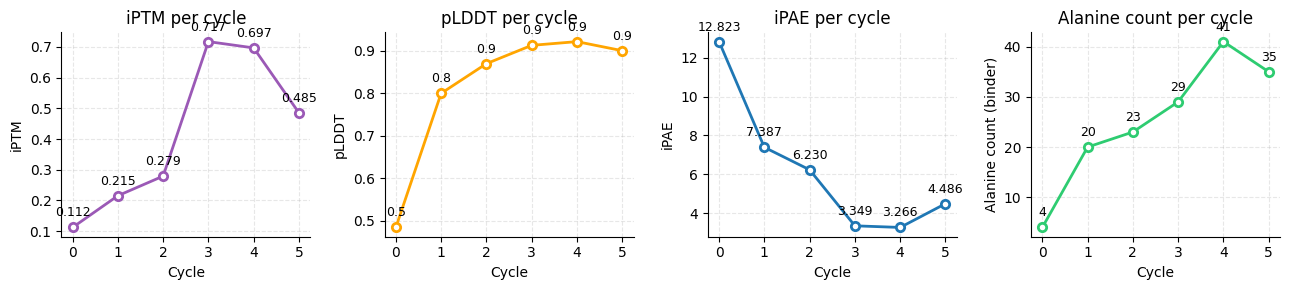

test_3/run_0 | Final Validation: score=0.803 plddt=0.9 ptm=0.944 iptm=0.767 ipae=2.98 ala=29 rmsd=0.38


In [5]:
# @title RUN
# @markdown input options
# @markdown -----
jobname = "test" # @param {"type":"string"}
binder_chain = "A" # @param {"type":"string"}
length = 150 # @param {"type":"integer"}
percent_X = 50 # @param ["0","50","100"] {"type":"raw"}

# @markdown optional settings
seq = "" # @param {"type":"string"}
target_chain = "B" # @param {"type":"string"}
target_seq = "O=C(NCc1cocn1)c1cnn(C)c1C(=O)Nc1ccn2cc(nc2n1)c1ccccc1" # @param {"type":"string"}
target_pdb = None # @param {"type":"string"}
target_pdb_chain = None # @param {"type":"string"}
cyclic = False # @param {"type":"boolean"}

# @markdown optimization options
# @markdown -----
n_trials = 1 # @param ["1","2","4","8","16"] {"type":"raw"}
n_cycles = 5 # @param ["0","1","2","3","5","10"] {"type":"raw"}
n_recycles = 3 # @param ["1","2","3"] {"type":"raw"}
n_diff_steps = 200 # @param ["50","100","200"] {"type":"raw"}
hysteresis_mode = "esm" # @param ["templates","esm","partial_diffusion", "none"]
repredict = True # @param {"type":"boolean"}

# @markdown mpnn options
# @markdown -----
omit_aa = "C" # @param {"type":"string"}
bias_aa = "A:-1.0"  # @param {"type":"string"} Amino acid types to bias (e.g., 'A:-2.0,P:-1.0').",
temperature = 0.01 # @param ["0.01","0.1","1.0"] {"type":"raw"}
scale_temp_by_plddt = False # @param {"type":"boolean"}
high_iptm_threshold = 0.8 # @param ["0.8","0.9","1.0"] {"type":"raw"}

# @markdown visual options
# @markdown -----
show_visual = True # @param {"type":"boolean"}
render_freq = 10 # @param ["1","10","100"] {"type":"raw"}
plot = True # @param {"type":"boolean"}


###############
# Parsing opts
###############

jobname = re.sub(r'\W+', '', jobname)
def check(folder): return os.path.exists(folder)
if check(jobname):
  n = 0
  while check(f"{jobname}_{n}"): n += 1
  jobname = f"{jobname}_{n}"

binder_mode = "none"
if is_smiles(target_seq):
  binder_mode = "ligand"
else:
  target_seq = clean_protein_sequence(target_seq)
  if target_seq == "":
    target_seq = None
  else:
    binder_mode = "protein"

seq = clean_protein_sequence(seq)

omit_AA = clean_protein_sequence(omit_aa)
if omit_AA == "": omit_AA = None

if show_visual:
  viewer = py2Dmol.view((600,400), color="plddt")
  viewer.show()
else:
  viewer = None

#####################
# hysteresis_mode
#####################
opts = dict(use_esm=False,
            use_esm_target=binder_mode == "protein",
            pde_cutoff_intra=0.0,
            pde_cutoff_inter=0.0,
            partial_diffusion=0.0)
if hysteresis_mode == "templates":
  opts["pde_cutoff_intra"] = 1.5
  opts["pde_cutoff_inter"] = 3.0
elif hysteresis_mode == "esm":
  opts["use_esm"] = True
  opts["use_esm_target"] = True
elif hysteresis_mode == "partial_diffusion":
  opts["partial_diffusion"] = 0.5

# Initialize folder and designer only if they don't exist
# This allows re-running the cell without re-initializing if desired,
# but the cleanup at the end will handle memory if run multiple times.
if "folder" not in locals() or folder is None:
    folder = ChaiFolder(device="cuda:0" if torch.cuda.is_available() else "cpu")
if "designer" not in locals() or designer is None:
    designer = LigandMPNNWrapper()

X = []
for t in range(n_trials):
  if seq == "":
    trial_seq = sample_seq(length, frac_X=percent_X/100)
  else:
    trial_seq = seq

  if viewer is not None:
    viewer.new_obj()

  x = optimize_protein_design(
      folder,
      designer,
      initial_seq=trial_seq,
      binder_chain=binder_chain,
      target_seq=target_seq,
      target_chain=target_chain,
      target_pdb=target_pdb,
      target_pdb_chain=target_pdb_chain,
      prefix=f"{jobname}/run_{t}",
      n_steps=n_cycles,
      num_trunk_recycles=n_recycles,
      num_diffn_timesteps=n_diff_steps,
      num_diffn_samples=1,
      temperature=temperature,
      scale_temp_by_plddt=scale_temp_by_plddt,
      use_alignment=True,
      align_to="all",
      randomize_template_sequence=True,
      omit_AA=omit_AA,
      cyclic=cyclic,
      verbose=False,
      viewer=viewer,
      render_freq=render_freq,
      final_validation=repredict,
      plot=plot,
      **opts
  )
  X.append(x)

  folder.full_cleanup()
  # Explicitly clear memory between trials
  gc.collect()
  if torch.cuda.is_available():
      torch.cuda.empty_cache()

#########################
# restore best of best
#########################
best_sco = 0
best_n = None
# Check if X is not empty before proceeding
if X:
    for n,x in enumerate(X):
      # Ensure result and ranking_score exist
      if x and x.get("state") and x["state"].result and "ranking_score" in x["state"].result:
          if x["state"].result["ranking_score"] > best_sco:
            best_sco = x["state"].result["ranking_score"]
            best_n = n
      else:
            print(f"Warning: Skipping trial {n} for best selection due to missing data.")
      folder.restore_state(X[best_n]["state"])
else:
    print("Warning: No successful trials completed.")
    # Handle case where X is empty

In [6]:
# @title Plot
folder.plot(color_by="plddt")

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [7]:
#@title download_prediction
from google.colab import files

#@markdown Once this cell has been executed, a zip-archive with
#@markdown the obtained prediction will be automatically downloaded
#@markdown to your computer.

# --- Download the predictions ---
os.system(f"zip -r {jobname}.zip {jobname}")
files.download(f'{jobname}.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>